#### 导入库

In [1]:
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from statsmodels.stats.weightstats import ztest
from scipy.stats import ttest_ind
import statsmodels.api as sm
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
from openai import OpenAI
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
import time
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from random import randint
from selenium.webdriver.common.action_chains import ActionChains
import random
from selenium.common.exceptions import WebDriverException
from tqdm.notebook import tqdm
import asyncio
from pyppeteer import launch
from pyppeteer import connect
import os
from pandas import json_normalize

#### 创建浏览器窗口

In [ ]:
options = Options()
options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36 Edg/122.0.0.0")
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_argument("--remote-debugging-port=9222")
options.add_experimental_option('excludeSwitches', ['enable-automation'])
options.add_experimental_option('useAutomationExtension', False)

# 启动Chrome
service = Service('./chromedriver.exe')  # 确保chromedriver.exe的路径正确
driver = webdriver.Chrome(service=service, options=options)
# 打开目标网页
driver.get('https://www.tokopedia.com/')

In [ ]:
# 点击登录按钮
wait = WebDriverWait(driver, 30)
wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'button[data-testid="btnHeaderLogin"]')))
daftar_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'button[data-testid="btnHeaderLogin"]')))
daftar_button.click()
time.sleep(randint(1, 5))

In [ ]:
time.sleep(randint(1, 5))
wait.until(EC.presence_of_element_located((By.XPATH, '//input[@type="email"]')))
time.sleep(3.2)
gmail_input = driver.find_element(By.XPATH, '//input[@type="email"]')
# 输入用户名和密码
gmail_input.send_keys('085173413262')

In [ ]:
time.sleep(randint(1, 5))
wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'button[data-testid="email-phone-submit"]')))
Selanjutnya_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'button[data-testid="email-phone-submit"]')))
Selanjutnya_button.click()

In [ ]:
time.sleep(randint(1, 5))
wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'div[aria-label="whatsapp"]')))
WhatsApp_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'div[aria-label="whatsapp"]')))
WhatsApp_button.click()

#### 抓取类目产品链接

输入类目链接

In [ ]:
driver.get('https://www.tokopedia.com/p/audio-kamera-elektronik-lainnya/vaporizer/e-cigarettes')

In [ ]:
def scroll_to_bottom(driver, scroll_pause_time=1):
    """滚动到网页底部以加载所有元素"""
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        # Scroll down to bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        # Wait to load page
        time.sleep(scroll_pause_time)
        # Calculate new scroll height and compare with last scroll height
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

def fetch_links(page_count):
    """抓取指定页数的产品链接"""
    links = []
    base_url = "https://www.tokopedia.com/p/audio-kamera-elektronik-lainnya/vaporizer/e-cigarettes?page="
    for page in tqdm(range(1, page_count + 1), desc='Fetching pages'):
        url = f"{base_url}{page}"
        driver.get(url)
        scroll_to_bottom(driver, scroll_pause_time=2)
        # 等待元素加载
        WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, "div.css-bk6tzz.e1nlzfl2 a"))
        )
        product_links = driver.find_elements(By.CSS_SELECTOR, "div.css-bk6tzz.e1nlzfl2 a")
        for link in product_links:
            links.append(link.get_attribute('href'))
    return links

#将链接保存到filename值名称的文件中
def save_links_to_file(links, filename="product_links.txt"):
    """将链接保存到文本文件中"""
    with open(filename, 'w', encoding='utf-8') as file:
        for link in links:
            file.write(f"{link}\n")

# 抓取的页面数，可以自己编辑
page_count = 130  # 示例为抓取5页
links = fetch_links(page_count)
save_links_to_file(links)

#### 抓取搜索关键词店铺产品链接

##### 抓取店铺链接

输入关键词

In [ ]:
time.sleep(randint(1, 5))
search_input = wait.until(EC.presence_of_element_located((By.XPATH, '//input[@type="search"]')))
# 搜索关键词
search_input.send_keys('relx')
time.sleep(randint(1, 5))
# 模拟按下回车键
search_input.send_keys(Keys.RETURN)

In [ ]:
time.sleep(randint(1, 5))
# 点击toko按钮
wait = WebDriverWait(driver, 30)
toko_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'button[data-testid="btnSRPShopTab"]')))
toko_button.click()

抓取店铺链接

In [ ]:
# 初始化店铺链接列表
store_links = []

try:
    while True:
        time.sleep(randint(1, 5))
        # 等待店铺卡片加载
        wait = WebDriverWait(driver, 10)
        shop_cards = wait.until(EC.presence_of_all_elements_located((By.XPATH, "//div[@data-testid='shop-card']")))

        # 提取每个店铺的链接
        for card in tqdm(shop_cards, total=len(store_links), desc="Processing links"):
            a_tag = card.find_element(By.TAG_NAME, 'a')
            store_links.append(a_tag.get_attribute('href'))

        # 检查'Toko Sudah Tidak Aktif'
        if driver.find_elements(By.XPATH, "//*[contains(text(), 'Toko Sudah Tidak Aktif')]"):
            break

        # 滚动到页面底部并点击下一页
        time.sleep(randint(1, 5))
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        next_page_button = wait.until(EC.element_to_be_clickable((By.XPATH, "//button[@aria-label='Laman berikutnya']")))
        next_page_button.click()

except Exception as e:
    print("发生错误:", e)

In [ ]:
store_links

In [ ]:
#写入店铺链接
with open('./store_links.txt', 'w') as file:
    file.writelines([f"{item}\n" for item in store_links])

##### 抓取产品链接

In [ ]:
with open('./store_links.txt', 'r') as file:
    store_links = file.read().splitlines()
end_index = 599
def scroll_down(driver, scroll_pause_time):
    """滚动页面一小段距离并等待新元素加载"""
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        # Scroll down to the bottom.
        driver.execute_script("window.scrollBy(0, arguments[0]);", last_height / 10)
        # Wait to load the page.
        time.sleep(scroll_pause_time)
        # Calculate new scroll height and compare with last scroll height.
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

# 定义一个文件来保存所有产品链接
filename = './all_product_links.txt'
product_links_set = set()
# 打开文件准备写入
with open(filename, 'w') as file:
    for index, link in tqdm(enumerate(store_links), total=len(store_links), desc="Processing links"):
        if index > end_index:
            break
        product_links = []  # 对每个店铺初始化产品链接列表
        try:
            driver.get(link)  # 打开店铺链接

            # 点击“产品”按钮以加载产品列表
            WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.CSS_SELECTOR, 'button[data-testid="Produk"]'))
            ).click()

            # 循环直到'没有更多产品'或者遇到'产品售罄'
            while True:
                time.sleep(randint(1, 3))
                scroll_down(driver, 2)
                # 收集当前页的所有产品链接
                product_elements = driver.find_elements(By.CSS_SELECTOR, 'div.css-1sn1xa2 a')
                for element in product_elements:
                    href = element.get_attribute('href')
                    # 只有当链接不在集合中时才添加，这样可以避免重复
                    if href not in product_links_set:
                        product_links_set.add(href)
                        file.write(f"{href}\n")
                

                # 确认页面中没有“Stok Habis”标识
                out_of_stock_elements = driver.find_elements(By.XPATH, "//div[contains(text(), 'Stok Habis')]")
                if out_of_stock_elements:
                    print(f"Stok Habis encountered, stopping the collection for {link}.")
                    break

                # 尝试找到并点击“下一页”按钮
                next_buttons = driver.find_elements(By.CSS_SELECTOR, 'a[data-testid="btnShopProductPageNext"]')
                if next_buttons:
                    try:
                        next_buttons[0].click()
                    except WebDriverException:
                        print("Next page button click failed. Maybe it's not clickable or covered by another element.")
                        break
                else:
                    print("No more pages, stopping the collection for this shop.")
                    break
        except WebDriverException as e:
            print(f"在处理链接 {link} 时出现错误：{e}，跳过此链接。")
            continue  # 跳过当前链接的剩余任务，继续下一个链接

        # 将当前店铺的产品链接写入文件
        for product_link in product_links:
            file.write(f"{product_link}\n")

print(f"All product links have been saved to {filename}.")

In [ ]:
product_links

In [ ]:
# 先读取您的产品链接列表
with open('./product_links.txt', 'r') as file:
    product_links = file.read().splitlines()

#### 抓取产品详情

In [ ]:

# 假设停止点是用户定义的，这里为了演示硬编码为第5个链接
stop_at_link_number = 6352

async def save_response_data(response, filename):
    if 'PDPGetLayoutQuery' in response.url:
        try:
            data = await response.json()
            with open(filename, 'w') as file:
                json.dump(data, file)
        except Exception as e:
            print(f'Error saving response data: {e}')

async def main(product_links,stop_at_link_number):
    browser = await connect(browserURL='http://127.0.0.1:9222')
    # 使用 tqdm 创建一个进度条，并以 stop_at_link_number 作为总量
    progress_bar = tqdm(total=stop_at_link_number, desc="Processing", unit="link")
    for index, url in enumerate(product_links, start=1):
        if index > stop_at_link_number:
            break  # 根据定义的停止点停止循环
        try:
            page = await browser.newPage()
            page.on('response', lambda response: asyncio.ensure_future(
                save_response_data(response, f'response_{index}.json')))
            await page.goto(url)
            await asyncio.sleep(3)  # 增加等待时间来处理数据
        except Exception as e:
            print(f'Error with the browser/page: {e}')
        finally:
            await page.close()
            progress_bar.update(1)  # 更新进度条
    progress_bar.close()  # 关闭进度条
        
    # 注意: 这里不关闭浏览器，因为是远程调试模式

# 从文件中读取产品链接
with open('./product_links.txt', 'r') as file:
    product_links = file.read().splitlines()

# 运行主函数
await main(product_links, stop_at_link_number=6352)


#### 导入数据

In [19]:
json_dir = './'
json_files = [os.path.join(json_dir, file) for file in os.listdir(json_dir) if file.endswith('.json')]

# 创建一个空列表来收集处理后的DataFrame
processed_dfs = []

# 逐个处理 JSON 文件
for file in tqdm(json_files):
    with open(file, 'r') as f:
        data = pd.read_json(f)

        # 假设每个 JSON 文件中都有一个 'data' 字段需要被展开
        # 我们在这里立即展开每个 'data' 字段
        # 注意：这假设 'data' 字段下面直接是一个字典或字典列表
        if 'data' in data.columns:
            if isinstance(data['data'].iloc[0], dict):
                # 如果 'data' 字段是字典，使用 pd.json_normalize 展开
                data = data.join(pd.json_normalize(data['data'])).drop('data', axis=1)
            elif isinstance(data['data'].iloc[0], list):
                # 如果 'data' 字段是列表，你需要进一步检查列表中的元素结构并展开
                pass  # 这里可以根据实际情况添加更多处理步骤

        # 收集处理后的 DataFrame
        processed_dfs.append(data)

# 最后，合并所有处理后的 DataFrame
all_data = pd.concat(processed_dfs, ignore_index=True)

  0%|          | 0/6320 [00:00<?, ?it/s]

In [37]:
all_data_original = all_data.copy()

In [23]:
all_data

,pdpGetLayout.requestID,pdpGetLayout.name,pdpGetLayout.pdpSession,pdpGetLayout.basicInfo.alias,pdpGetLayout.basicInfo.createdAt,pdpGetLayout.basicInfo.isQA,pdpGetLayout.basicInfo.id,pdpGetLayout.basicInfo.shopID,pdpGetLayout.basicInfo.shopName,pdpGetLayout.basicInfo.minOrder,...,pdpGetLayout.basicInfo.stats.countView,pdpGetLayout.basicInfo.stats.countReview,pdpGetLayout.basicInfo.stats.countTalk,pdpGetLayout.basicInfo.stats.rating,pdpGetLayout.basicInfo.stats.__typename,pdpGetLayout.basicInfo.__typename,pdpGetLayout.components,pdpGetLayout.__typename,errors,pdpGetLayout
0,cnvfjar6p33jbpao05v0,Default Layout Desktop,"{""sid"":13032496,""sd"":""relxjawatimur"",""cat"":{""i...",relx-artisan-metal-device-all-colors-silver-wa...,2023-09-09T00:23:02+07:00,False,11539948996,13032496,RELX Jawa Timur,1.0,...,1021,6,0,5.0,pdpStats,pdpBasicInfo,"[{'name': 'product_media', 'type': 'product_me...",pdpLayout,NaN,NaN
1,cnvfkgj6p33g20kl8qig,Default Layout Desktop,"{""sid"":9116741,""sd"":""relxnow-id"",""cat"":{""id"":3...",relx-infinity-2-device-cherry-blossom,2023-07-26T18:56:08+07:00,False,10871075480,9116741,Official Store RELX,1.0,...,11000,51,1,4.9,pdpStats,pdpBasicInfo,"[{'name': 'product_media', 'type': 'product_me...",pdpLayout,NaN,NaN
2,cnvfn9b6p33jbpapp12g,Default Layout Desktop,"{""sid"":9116741,""sd"":""relxnow-id"",""cat"":{""id"":3...",waka-sopro-disposable-pod-minty-lemon,2023-08-28T18:27:36+07:00,False,11394537189,9116741,Official Store RELX,1.0,...,2254,25,0,5.0,pdpStats,pdpBasicInfo,"[{'name': 'product_media', 'type': 'product_me...",pdpLayout,NaN,NaN
3,cnvgikj6p33g146g8mu0,Default Layout Desktop,"{""sid"":14205581,""sd"":""relxsanur"",""cat"":{""id"":3...",relx-infinity-pod-pro-watermelon-ice-semangka-...,2022-08-01T00:38:24+07:00,False,5133108864,14205581,RELX SANUR,1.0,...,420,8,0,5.0,pdpStats,pdpBasicInfo,"[{'name': 'product_media', 'type': 'product_me...",pdpLayout,NaN,NaN
4,cnvgilj6p33g25netea0,Default Layout Desktop,"{""sid"":14535810,""sd"":""mevolindonesia"",""cat"":{""...",mevol-x-pods-juicy-watermelon,2022-10-14T17:46:35+07:00,False,6748754318,14535810,MEVOL INDONESIA,1.0,...,401,15,1,5.0,pdpStats,pdpBasicInfo,"[{'name': 'product_media', 'type': 'product_me...",pdpLayout,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6315,cnvgifr6p33ht0f03rt0,Default Layout Desktop,"{""sid"":279266,""sd"":""liandradiid"",""cat"":{""id"":3...",new-iqos-3-limited-edition,2019-12-23T16:15:02+07:00,False,638511556,279266,Liandradi_id,1.0,...,3694,1,5,5.0,pdpStats,pdpBasicInfo,"[{'name': 'product_media', 'type': 'product_me...",pdpLayout,NaN,NaN
6316,cnvgigj6p33gaj5rf56g,Default Layout Desktop,"{""sid"":855572,""sd"":""usahabarokah1"",""cat"":{""id""...",heets-iqos-purple-sienna-amber-bronze-green-bl...,2022-03-28T19:58:04+07:00,False,3366252202,855572,Usaha Barokah 1,1.0,...,4469,84,4,4.9,pdpStats,pdpBasicInfo,"[{'name': 'product_media', 'type': 'product_me...",pdpLayout,NaN,NaN
6317,cnvgihj6p33g81mq1us0,Default Layout Desktop,"{""sid"":15946208,""sd"":""ostore-82"",""cat"":{""id"":3...",relx-pod-pro-2-hibiscus-ice-tea-isi-1-pod,2023-10-12T19:57:54+07:00,False,11818824797,15946208,Official Store Permata,1.0,...,35,3,0,5.0,pdpStats,pdpBasicInfo,"[{'name': 'product_media', 'type': 'product_me...",pdpLayout,NaN,NaN
6318,cnvgiij6p33g146g7rqg,Default Layout Desktop,"{""sid"":12149518,""sd"":""relxoriginalauthent"",""ca...",relx-infinity-pods-pro-menthol-xtra-original-a...,2021-09-08T06:04:39+07:00,False,2147280448,12149518,RELX Original Authentic,1.0,...,2562,131,3,4.9,pdpStats,pdpBasicInfo,"[{'name': 'product_media', 'type': 'product_me...",pdpLayout,NaN,NaN


##### 展开数据

In [45]:
# 创建一个新的 DataFrame，用于存储扩展的数据
expanded_data = pd.DataFrame(index=all_data.index)

# 提取并展开特定组件中的数据
for idx, row in all_data.iterrows():
    if isinstance(row['pdpGetLayout.components'], list) and len(row['pdpGetLayout.components']) > 3:
        component = row['pdpGetLayout.components'][3]  # 提取第四个组件
        if 'data' in component and component['data']:
            data = component['data'][0]  # 提取data键的字典

            # 获取要作为前缀的字典名或类型
            prefix = component.get('name', 'unknown') + '_'

            # 创建列并添加前缀
            for key in data.keys():
                column_name = prefix + key
                if column_name not in expanded_data:
                    expanded_data[column_name] = pd.NA
                expanded_data.at[idx, column_name] = data[key]

# 合并原始DataFrame和扩展的数据
result_data = pd.concat([all_data, expanded_data], axis=1)

# 删除原始的 'pdpGetLayout.components' 列
result_data.drop(columns=['pdpGetLayout.components'], inplace=True)


In [56]:
# 假设 df 是拆分后的 DataFrame，并且所有的字典都已经被展开到了新列
def expand_nested_dict(result_data, col_prefix):
    for col in result_data.columns:
        # 只处理有指定前缀的列
        if col.startswith(col_prefix) and result_data[col].dtype == 'object':
            # 将字典展开为多个列
            dict_df = result_data[col].apply(pd.Series)
            dict_df.columns = [f"{col}_{subcol}" for subcol in dict_df.columns]
            result_data = pd.concat([result_data, dict_df], axis=1).drop(columns=[col])
    return result_data

# 调用函数，假设所有以'product_content_'开始的列都是需要展开的字典
result_data = expand_nested_dict(result_data, 'product_content_')

In [59]:
result_data.sample(50)

,pdpGetLayout.requestID,pdpGetLayout.name,pdpGetLayout.pdpSession,pdpGetLayout.basicInfo.alias,pdpGetLayout.basicInfo.createdAt,pdpGetLayout.basicInfo.isQA,pdpGetLayout.basicInfo.id,pdpGetLayout.basicInfo.shopID,pdpGetLayout.basicInfo.shopName,pdpGetLayout.basicInfo.minOrder,pdpGetLayout.basicInfo.maxOrder,pdpGetLayout.basicInfo.weight,pdpGetLayout.basicInfo.weightUnit,pdpGetLayout.basicInfo.condition,pdpGetLayout.basicInfo.status,pdpGetLayout.basicInfo.url,pdpGetLayout.basicInfo.needPrescription,pdpGetLayout.basicInfo.catalogID,pdpGetLayout.basicInfo.isLeasing,pdpGetLayout.basicInfo.isBlacklisted,pdpGetLayout.basicInfo.isTokoNow,pdpGetLayout.basicInfo.menu.id,pdpGetLayout.basicInfo.menu.name,pdpGetLayout.basicInfo.menu.url,pdpGetLayout.basicInfo.menu.__typename,pdpGetLayout.basicInfo.category.id,pdpGetLayout.basicInfo.category.name,pdpGetLayout.basicInfo.category.title,pdpGetLayout.basicInfo.category.breadcrumbURL,pdpGetLayout.basicInfo.category.isAdult,pdpGetLayout.basicInfo.category.isKyc,pdpGetLayout.basicInfo.category.minAge,pdpGetLayout.basicInfo.category.detail,pdpGetLayout.basicInfo.category.__typename,pdpGetLayout.basicInfo.txStats.transactionSuccess,pdpGetLayout.basicInfo.txStats.transactionReject,pdpGetLayout.basicInfo.txStats.countSold,pdpGetLayout.basicInfo.txStats.paymentVerified,pdpGetLayout.basicInfo.txStats.itemSoldFmt,pdpGetLayout.basicInfo.txStats.__typename,pdpGetLayout.basicInfo.stats.countView,pdpGetLayout.basicInfo.stats.countReview,pdpGetLayout.basicInfo.stats.countTalk,pdpGetLayout.basicInfo.stats.rating,pdpGetLayout.basicInfo.stats.__typename,pdpGetLayout.basicInfo.__typename,pdpGetLayout.__typename,errors,pdpGetLayout,name,isOS,isPowerMerchant,isWishlist,isCOD,preorder,__typename,price_discPercentage,price_currency,price_slashPriceFmt,price___typename,price_value,price_priceFmt,campaign_startDate,campaign_campaignIdentifier,campaign_stockSoldPercentage,campaign_threshold,campaign_hideGimmick,campaign_percentageAmount,campaign_isActive,campaign_stock,campaign_originalStock,campaign_endDate,campaign_originalPrice,campaign_endDateUnix,campaign_campaignType,campaign_isAppsOnly,campaign_discountedPrice,campaign_appLinks,campaign_campaignID,campaign___typename,campaign_campaignTypeName,campaign_background,thematicCampaign_icon,thematicCampaign_additionalInfo,thematicCampaign___typename,thematicCampaign_background,thematicCampaign_campaignName,stock___typename,stock_useStock,stock_value,stock_stockWording,variant___typename,variant_parentID,variant_isVariant,isCashback_percentage,isCashback___typename,product_content_name_0,product_content_price_value,product_content_price_currency,product_content_price_priceFmt,product_content_price_slashPriceFmt,product_content_price_discPercentage,product_content_price___typename,product_content_price_0,product_content_campaign_campaignID,product_content_campaign_campaignType,product_content_campaign_campaignTypeName,product_content_campaign_campaignIdentifier,product_content_campaign_background,product_content_campaign_percentageAmount,product_content_campaign_originalPrice,product_content_campaign_discountedPrice,product_content_campaign_originalStock,product_content_campaign_stock,product_content_campaign_stockSoldPercentage,product_content_campaign_threshold,product_content_campaign_startDate,product_content_campaign_endDate,product_content_campaign_endDateUnix,product_content_campaign_appLinks,product_content_campaign_isAppsOnly,product_content_campaign_isActive,product_content_campaign_hideGimmick,product_content_campaign___typename,product_content_campaign_0,product_content_thematicCampaign_additionalInfo,product_content_thematicCampaign_background,product_content_thematicCampaign_campaignName,product_content_thematicCampaign_icon,product_content_thematicCampaign___typename,product_content_thematicCampaign_0,product_content_stock_useStock,product_content_stock_value,product_content_stock_stockWording,product_content_stock___typename,product_content_stock_0,product

##### 展示列名筛选保留列

In [58]:
pd.set_option("display.max_columns",None)
column_names = result_data.columns.tolist()
column_names

['pdpGetLayout.requestID',
 'pdpGetLayout.name',
 'pdpGetLayout.pdpSession',
 'pdpGetLayout.basicInfo.alias',
 'pdpGetLayout.basicInfo.createdAt',
 'pdpGetLayout.basicInfo.isQA',
 'pdpGetLayout.basicInfo.id',
 'pdpGetLayout.basicInfo.shopID',
 'pdpGetLayout.basicInfo.shopName',
 'pdpGetLayout.basicInfo.minOrder',
 'pdpGetLayout.basicInfo.maxOrder',
 'pdpGetLayout.basicInfo.weight',
 'pdpGetLayout.basicInfo.weightUnit',
 'pdpGetLayout.basicInfo.condition',
 'pdpGetLayout.basicInfo.status',
 'pdpGetLayout.basicInfo.url',
 'pdpGetLayout.basicInfo.needPrescription',
 'pdpGetLayout.basicInfo.catalogID',
 'pdpGetLayout.basicInfo.isLeasing',
 'pdpGetLayout.basicInfo.isBlacklisted',
 'pdpGetLayout.basicInfo.isTokoNow',
 'pdpGetLayout.basicInfo.menu.id',
 'pdpGetLayout.basicInfo.menu.name',
 'pdpGetLayout.basicInfo.menu.url',
 'pdpGetLayout.basicInfo.menu.__typename',
 'pdpGetLayout.basicInfo.category.id',
 'pdpGetLayout.basicInfo.category.name',
 'pdpGetLayout.basicInfo.category.title',
 'pdpG

筛选保留的列

'pdpGetLayout.basicInfo.id',——产品id  
'pdpGetLayout.basicInfo.shopID',——店铺id  
'pdpGetLayout.basicInfo.shopName',——店铺名  
'pdpGetLayout.basicInfo.minOrder',——最小订单  
'pdpGetLayout.basicInfo.maxOrder',——最大订单  
'pdpGetLayout.basicInfo.weight',——重量  
'pdpGetLayout.basicInfo.weightUnit',——重量单位  
'pdpGetLayout.basicInfo.status',——产品状态  
'pdpGetLayout.basicInfo.url',——产品链接  
'pdpGetLayout.basicInfo.menu.id',——店铺导航id  
'pdpGetLayout.basicInfo.menu.name',——店铺导航名称  
'pdpGetLayout.basicInfo.menu.url',——店铺导航链接  
'pdpGetLayout.basicInfo.category.id',——类目id  
'pdpGetLayout.basicInfo.category.name',——类目名称  
'pdpGetLayout.basicInfo.category.breadcrumbURL',——类目链接  
'pdpGetLayout.basicInfo.txStats.transactionSuccess',——交易成功数量  
'pdpGetLayout.basicInfo.txStats.transactionReject',——交易拒绝数量  
'pdpGetLayout.basicInfo.txStats.countSold',——销售数量  
'pdpGetLayout.basicInfo.txStats.paymentVerified',——完成付款数量  
'pdpGetLayout.basicInfo.txStats.itemSoldFmt',——已售商品数量  
'pdpGetLayout.basicInfo.stats.countView',——访问数量  
'pdpGetLayout.basicInfo.stats.countReview',——评价数量  
'pdpGetLayout.basicInfo.stats.countTalk',——问答数量  
'pdpGetLayout.basicInfo.stats.rating'——评分  Cshback_percentage',
 'i:'产品名',Cshback___typename',
 'produc:'产品价格',_ontent_name_0',
 'product_conte:'币种'_ontent_price___typename',
 'product_:'活动ID',otent_price_0',
 'product_content_campa:'活动类型',g_campaignID',
 'product_content_campaign_c:'活动类型名称',mmpaignIdentifier',
 'product_content_campa:'活动折扣',g_background',
 'product_content_campaig:'活动产品原价',_ercentageAmount',
 'product_content_campa:'活动产品折扣价',g_originalPrice',
 'product_content_camp:'活动原始库存',in_discountedPrice',
 'product_c:'活动库存',nent_campaign_originalStock',
 'product_conten:'活动库存销售比例',_ampaign_stock',
 'product_content_c:'活动临界点',maign_stockSoldPercentage',
 'produc:'活动开始日期',_ontent_campaign_threshold',
 'pro:'活动结束日期',ut_content_campaign_startDate',
 'prod:'活动结束时间戳',c_content_campaign_endDate',
 'prod:'活动链接',c_content_campaign_endDateUnix',
 'pr:'活动是否仅限移动端',dct_content_campaign_appLinks',
 'p:'活动是否上线',ouct_content_campaign_isAppsOnly',
 'p:'活动是否隐藏促销元素',o',
 'product_content_campaign___typename',
 'pr:'专题活动附加信息',dticCampaign_additionalInfo',
 'product_content:'专题活动名称',tuct_content_thematicCampaign___t:'产品与否有库存',pname',
 'product_content_the:'产品库存数',atock_stockWording',
 'product_cont:'是否有变体',n_stock___typename',
 'product_con:'变体父ID', product_content_wholesale_2',
 'produc:'返现百分比',_'product
 'product_content_isCashback:'是否是认证商家'product 'product_content_isPowerMe:'预购持续时间',chant_',
 'product_content_isWishli:'预购时间戳',t_0', 'product_content_isCOD_0',
 :'是否预购',produc_content_preorder_duration',
 'prod:'预购天数',erInDays',
 'product_content_preorder___typename',
 'product_content_preorder_0',
 'product_content___typename_0']

In [62]:
column_names_clean = ['pdpGetLayout.basicInfo.id','pdpGetLayout.basicInfo.shopID','pdpGetLayout.basicInfo.shopName',
                      'pdpGetLayout.basicInfo.minOrder','pdpGetLayout.basicInfo.maxOrder','pdpGetLayout.basicInfo.weight',
                      'pdpGetLayout.basicInfo.weightUnit','pdpGetLayout.basicInfo.status','pdpGetLayout.basicInfo.url',
                      'pdpGetLayout.basicInfo.menu.id','pdpGetLayout.basicInfo.menu.name','pdpGetLayout.basicInfo.menu.url',
                      'pdpGetLayout.basicInfo.category.id','pdpGetLayout.basicInfo.category.name',
                      'pdpGetLayout.basicInfo.category.breadcrumbURL','pdpGetLayout.basicInfo.txStats.transactionSuccess',
                      'pdpGetLayout.basicInfo.txStats.transactionReject','pdpGetLayout.basicInfo.txStats.countSold',
                      'pdpGetLayout.basicInfo.txStats.paymentVerified','pdpGetLayout.basicInfo.txStats.itemSoldFmt',
                      'pdpGetLayout.basicInfo.stats.countView','pdpGetLayout.basicInfo.stats.countReview',
                      'pdpGetLayout.basicInfo.stats.countTalk','pdpGetLayout.basicInfo.stats.rating','product_content_name_0',
                      'product_content_price_value','product_content_price_currency','product_content_campaign_campaignID',
                      'product_content_campaign_campaignType','product_content_campaign_campaignTypeName','product_content_campaign_percentageAmount',
                      'product_content_campaign_originalPrice','product_content_campaign_discountedPrice','product_content_campaign_originalStock',
                      'product_content_campaign_stock','product_content_campaign_stockSoldPercentage','product_content_campaign_threshold',
                      'product_content_campaign_startDate','product_content_campaign_endDate','product_content_campaign_endDateUnix',
                      'product_content_campaign_appLinks','product_content_campaign_isAppsOnly','product_content_campaign_isActive',
                      'product_content_campaign_hideGimmick','product_content_thematicCampaign_additionalInfo',
                      'product_content_thematicCampaign_campaignName','product_content_stock_useStock','product_content_stock_value',
                      'product_content_variant_isVariant','product_content_variant_parentID','product_content_isCashback_percentage',
                      'product_content_isPowerMerchant_0','product_content_preorder_duration','product_content_preorder_timeUnit',
                      'product_content_preorder_isActive','product_content_preorder_preorderInDays','product_content_isOS_0']
all_data_expanded = result_data[column_names_clean]
all_data_expanded

,pdpGetLayout.basicInfo.id,pdpGetLayout.basicInfo.shopID,pdpGetLayout.basicInfo.shopName,pdpGetLayout.basicInfo.minOrder,pdpGetLayout.basicInfo.maxOrder,pdpGetLayout.basicInfo.weight,pdpGetLayout.basicInfo.weightUnit,pdpGetLayout.basicInfo.status,pdpGetLayout.basicInfo.url,pdpGetLayout.basicInfo.menu.id,pdpGetLayout.basicInfo.menu.name,pdpGetLayout.basicInfo.menu.url,pdpGetLayout.basicInfo.category.id,pdpGetLayout.basicInfo.category.name,pdpGetLayout.basicInfo.category.breadcrumbURL,pdpGetLayout.basicInfo.txStats.transactionSuccess,pdpGetLayout.basicInfo.txStats.transactionReject,pdpGetLayout.basicInfo.txStats.countSold,pdpGetLayout.basicInfo.txStats.paymentVerified,pdpGetLayout.basicInfo.txStats.itemSoldFmt,pdpGetLayout.basicInfo.stats.countView,pdpGetLayout.basicInfo.stats.countReview,pdpGetLayout.basicInfo.stats.countTalk,pdpGetLayout.basicInfo.stats.rating,product_content_name_0,product_content_price_value,product_content_price_currency,product_content_campaign_campaignID,product_content_campaign_campaignType,product_content_campaign_campaignTypeName,product_content_campaign_percentageAmount,product_content_campaign_originalPrice,product_content_campaign_discountedPrice,product_content_campaign_originalStock,product_content_campaign_stock,product_content_campaign_stockSoldPercentage,product_content_campaign_threshold,product_content_campaign_startDate,product_content_campaign_endDate,product_content_campaign_endDateUnix,product_content_campaign_appLinks,product_content_campaign_isAppsOnly,product_content_campaign_isActive,product_content_campaign_hideGimmick,product_content_thematicCampaign_additionalInfo,product_content_thematicCampaign_campaignName,product_content_stock_useStock,product_content_stock_value,product_content_variant_isVariant,product_content_variant_parentID,product_content_isCashback_percentage,product_content_isPowerMerchant_0,product_content_preorder_duration,product_content_preorder_timeUnit,product_content_preorder_isActive,product_content_preorder_preorderInDays,product_content_isOS_0
0,11539948996,13032496,RELX Jawa Timur,1.0,92.0,100.0,GRAM,ACTIVE,https://www.tokopedia.com/relxjawatimur/relx-a...,0,,,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,16,0,16,17,17,1021,6,0,5.0,Relx Artisan Metal Device All Colors - Silver ...,600000.0,IDR,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0,,False,False,False,Diskon hingga 100rb,Beli Lokal,True,92,True,11539948992,0.0,True,0.0,,False,0.0,False
1,10871075480,9116741,Official Store RELX,1.0,22.0,200.0,GRAM,ACTIVE,https://www.tokopedia.com/relxnow-id/relx-infi...,35228626,Infinity 2 Device,https://www.tokopedia.com/relxnow-id/etalase/i...,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,212,0,213,214,100+,11000,51,1,4.9,RELX Infinity 2 Device - Cherry Blossom,330000.0,IDR,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0,,False,False,False,Elektronik Banting Harga s.d 80%,Mega Electrodeals,True,22,False,0,0.0,True,0.0,,False,0.0,True
2,11394537189,9116741,Official Store RELX,1.0,18.0,50.0,GRAM,ACTIVE,https://www.tokopedia.com/relxnow-id/waka-sopr...,34482267,Disposable,https://www.tokopedia.com/relxnow-id/etalase/d...,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,59,0,85,60,80+,2254,25,0,5.0,WAKA soPro Disposable Pod - Minty Lemon,100000.0,IDR,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0,,False,False,False,,,True,18,False,0,0.0,True,0.0,,False,0.0,True
3,5133108864,14205581,RELX SANUR,1.0,99.0,300.0,GRAM,ACTIVE,https://www.tokopedia.com/relxsanur/relx-infin...,32490546,Relx Cartridge Ceramic Coil PRO 1 PCS,https://www.tokopedia.com/relxsanur/etalase/re...,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,22,0,108,22,100+,420,8,0,5.0,RELX Infinity Pod PRO WATERMELON ICE / SEMANGK...,80000.0,IDR,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0,,False,False,False,,,True,99,False,0,0.0,True,0.0,,False,0.0,False
4,6748754318,14535810,MEVOL INDONESIA,1.0,60.0,300.0,GRAM,ACTIVE,https://www.tokopedia.com/mevolindonesia/mevol...,34042

替换列名

In [63]:
all_cleandata_expanded = all_data_expanded.rename(columns={'pdpGetLayout.basicInfo.id':'产品id', 'pdpGetLayout.basicInfo.shopID':'店铺id',
                                                            'pdpGetLayout.basicInfo.shopName':'店铺名','pdpGetLayout.basicInfo.minOrder':'最小订单',
                                                            'pdpGetLayout.basicInfo.maxOrder':'最大订单','pdpGetLayout.basicInfo.weight':'重量',
                                                            'pdpGetLayout.basicInfo.weightUnit':'重量单位','pdpGetLayout.basicInfo.status':'产品状态',
                                                            'pdpGetLayout.basicInfo.url':'产品链接','pdpGetLayout.basicInfo.menu.id':'店铺导航id',
                                                            'pdpGetLayout.basicInfo.menu.name':'店铺导航名称','pdpGetLayout.basicInfo.menu.url':'店铺导航链接',
                                                            'pdpGetLayout.basicInfo.category.id':'类目id','pdpGetLayout.basicInfo.category.name':'类目名称',
                                                            'pdpGetLayout.basicInfo.category.breadcrumbURL':'类目链接','pdpGetLayout.basicInfo.txStats.transactionSuccess':'交易成功数量',
                                                            'pdpGetLayout.basicInfo.txStats.transactionReject':'交易拒绝数量','pdpGetLayout.basicInfo.txStats.countSold':'销售数量',
                                                            'pdpGetLayout.basicInfo.txStats.paymentVerified':'完成付款数量','pdpGetLayout.basicInfo.txStats.itemSoldFmt':'已售商品数量',
                                                            'pdpGetLayout.basicInfo.stats.countView':'访问数量','pdpGetLayout.basicInfo.stats.countReview':'评价数量',
                                                            'pdpGetLayout.basicInfo.stats.countTalk':'问答数量','pdpGetLayout.basicInfo.stats.rating':'评分',
                                                           'product_content_name_0':'产品名','product_content_price_value':'产品价格','product_content_price_currency':'币种',
                                                           'product_content_campaign_campaignID':'活动ID','product_content_campaign_campaignType':'活动类型',
                                                           'product_content_campaign_campaignTypeName':'活动类型名称','product_content_campaign_percentageAmount':'活动折扣',
                                                           'product_content_campaign_originalPrice':'活动产品原价','product_content_campaign_discountedPrice':'活动产品折扣价',
                                                           'product_content_campaign_originalStock':'活动原始库存','product_content_campaign_stock':'活动库存',
                                                           'product_content_campaign_stockSoldPercentage':'活动库存销售比例','product_content_campaign_threshold':'活动临界点',
                                                           'product_content_campaign_startDate':'活动开始日期','product_content_campaign_endDate':'活动结束日期',
                                                           'product_content_campaign_endDateUnix':'活动结束时间戳','product_content_campaign_appLinks':'活动链接',
                                                           'product_content_campaign_isAppsOnly':'活动是否仅限移动端','product_content_campaign_isActive':'活动是否上线',
                                                           'product_content_campaign_hideGimmick':'活动是否隐藏促销元素','product_content_thematicCampaign_additionalInfo':'专题活动附加信息',
                                                           'product_content_thematicCampaign_campaignName':'专题活动名称','product_content_stock_useStock':'产品与否有库存',
                                                           'product_content_stock_value':'产品库存数','product_content_variant_isVariant':'是否有变体',
                                                           'product_content_variant_parentID':'变体父ID','product_content_isCashback_percentage':'返现百分比',
                                                           'product_content_isPowerMerchant_0':'是否是认证商家','product_content_preorder_duration':'预购持续时间',
                                                           'product_content_preorder_timeUnit':'预购时间戳','product_content_preorder_isActive':'是否预购',
                                                           'product_content_preorder_preorderInDays':'预购天数','product_content_isOS_0':'是否在售'})
all_cleandata_expanded

,产品id,店铺id,店铺名,最小订单,最大订单,重量,重量单位,产品状态,产品链接,店铺导航id,店铺导航名称,店铺导航链接,类目id,类目名称,类目链接,交易成功数量,交易拒绝数量,销售数量,完成付款数量,已售商品数量,访问数量,评价数量,问答数量,评分,产品名,产品价格,币种,活动ID,活动类型,活动类型名称,活动折扣,活动产品原价,活动产品折扣价,活动原始库存,活动库存,活动库存销售比例,活动临界点,活动开始日期,活动结束日期,活动结束时间戳,活动链接,活动是否仅限移动端,活动是否上线,活动是否隐藏促销元素,专题活动附加信息,专题活动名称,产品与否有库存,产品库存数,是否有变体,变体父ID,返现百分比,是否是认证商家,预购持续时间,预购时间戳,是否预购,预购天数,是否在售
0,11539948996,13032496,RELX Jawa Timur,1.0,92.0,100.0,GRAM,ACTIVE,https://www.tokopedia.com/relxjawatimur/relx-a...,0,,,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,16,0,16,17,17,1021,6,0,5.0,Relx Artisan Metal Device All Colors - Silver ...,600000.0,IDR,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0,,False,False,False,Diskon hingga 100rb,Beli Lokal,True,92,True,11539948992,0.0,True,0.0,,False,0.0,False
1,10871075480,9116741,Official Store RELX,1.0,22.0,200.0,GRAM,ACTIVE,https://www.tokopedia.com/relxnow-id/relx-infi...,35228626,Infinity 2 Device,https://www.tokopedia.com/relxnow-id/etalase/i...,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,212,0,213,214,100+,11000,51,1,4.9,RELX Infinity 2 Device - Cherry Blossom,330000.0,IDR,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0,,False,False,False,Elektronik Banting Harga s.d 80%,Mega Electrodeals,True,22,False,0,0.0,True,0.0,,False,0.0,True
2,11394537189,9116741,Official Store RELX,1.0,18.0,50.0,GRAM,ACTIVE,https://www.tokopedia.com/relxnow-id/waka-sopr...,34482267,Disposable,https://www.tokopedia.com/relxnow-id/etalase/d...,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,59,0,85,60,80+,2254,25,0,5.0,WAKA soPro Disposable Pod - Minty Lemon,100000.0,IDR,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0,,False,False,False,,,True,18,False,0,0.0,True,0.0,,False,0.0,True
3,5133108864,14205581,RELX SANUR,1.0,99.0,300.0,GRAM,ACTIVE,https://www.tokopedia.com/relxsanur/relx-infin...,32490546,Relx Cartridge Ceramic Coil PRO 1 PCS,https://www.tokopedia.com/relxsanur/etalase/re...,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,22,0,108,22,100+,420,8,0,5.0,RELX Infinity Pod PRO WATERMELON ICE / SEMANGK...,80000.0,IDR,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0,,False,False,False,,,True,99,False,0,0.0,True,0.0,,False,0.0,False
4,6748754318,14535810,MEVOL INDONESIA,1.0,60.0,300.0,GRAM,ACTIVE,https://www.tokopedia.com/mevolindonesia/mevol...,34042336,MEVOL X REFILL,https://www.tokopedia.com/mevolindonesia/etala...,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,33,0,41,32,40+,401,15,1,5.0,Mevol X Pods Juicy Watermelon,90000.0,IDR,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0,,False,False,False,,,True,60,False,0,0.0,True,0.0,,False,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6315,638511556,279266,Liandradi_id,1.0,2.0,500.0,GRAM,ACTIVE,https://www.tokopedia.com/liandradiid/new-iqos...,7928940,Kesehatan,https://www.tokopedia.com/liandradiid/etalase/...,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,2,1,2,2,2,3694,1,5,5.0,New IQOS 3 Limited Edition,750000.0,IDR,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0,,False,False,False,,,True,2,False,0,0.0,True,0.0,,False,0.0,False
6316,3366252202,855572,Usaha Barokah 1,1.0,19.0,350.0,GRAM,ACTIVE,https://www.tokopedia.com/usahabarokah1/heets-...,31048012,Heets iQos Heatstick and Device,https://www.tokopedia.com/usahabarokah1/etalas...,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,165,13,270,177,250+,4469,84,4,4.9,Heets iQos purple sienna amber bronze green bl...,295000.0,IDR,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0,,False,False,False,,,True,19,True,2006259487,0.0,False,0.0,,False,0.0,False
6317,11818824797,15946208,Official Store Permata,1.0,998.0,10.0,GRAM,ACTIVE,https://www.tokopedia.com/ostore-82/relx-pod-p...,0,,,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,5,0,6,5,6,35,3,0,5.0,RELX Pod Pro 2 - Hibiscus Ice Tea (Isi 1 P

#### 清洗数据

保存为csv

In [66]:
all_cleandata_expanded.to_csv('E_cigarette_tokopedia_data.csv', index=False)

读取csv

In [6]:
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",100)

In [37]:
all_cleandata_expanded = pd.read_csv('E_cigarette_tokopedia_data.csv')

In [38]:
all_cleandata_expanded.sample(100)

,产品id,店铺id,店铺名,最小订单,最大订单,重量,重量单位,产品状态,产品链接,店铺导航id,店铺导航名称,店铺导航链接,类目id,类目名称,类目链接,交易成功数量,交易拒绝数量,销售数量,完成付款数量,已售商品数量,访问数量,评价数量,问答数量,评分,产品名,产品价格,币种,活动ID,活动类型,活动类型名称,活动折扣,活动产品原价,活动产品折扣价,活动原始库存,活动库存,活动库存销售比例,活动临界点,活动开始日期,活动结束日期,活动结束时间戳,活动链接,活动是否仅限移动端,活动是否上线,活动是否隐藏促销元素,专题活动附加信息,专题活动名称,产品与否有库存,产品库存数,是否有变体,变体父ID,返现百分比,是否是认证商家,预购持续时间,预购时间戳,是否预购,预购天数,是否在售
2108,1.046598e+10,15963253.0,RAW_J_SLANK,1.0,11.0,1000.00,GRAM,ACTIVE,https://www.tokopedia.com/rawjslank/iqos-heets...,0.0,NaN,NaN,3911.0,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,0.0,1.0,0.0,1.0,NaN,124.0,0.0,0.0,0.0,iqos heets yugen,18200.0,IDR,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000e+00,NaN,False,False,False,NaN,NaN,True,11.0,False,0.000000e+00,0.0,False,0.0,NaN,False,0.0,False
6223,1.175980e+10,12149518.0,RELX Original Authentic,2.0,74.0,10.00,GRAM,ACTIVE,https://www.tokopedia.com/relxoriginalauthent/...,0.0,NaN,NaN,3911.0,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,9.0,1.0,22.0,11.0,26,122.0,3.0,0.0,4.7,RELX Pods Infinity 2 - Jasmin Green Tea,75000.0,IDR,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000e+00,NaN,False,False,False,NaN,NaN,True,74.0,False,0.000000e+00,0.0,True,0.0,NaN,False,0.0,False
2058,9.909759e+09,8765255.0,RELX GD OFFICIAL KELAPA GADING,1.0,5.0,125.00,GRAM,ACTIVE,https://www.tokopedia.com/relx-gd-official/rel...,34478209.0,Bundle Infinity Plus,https://www.tokopedia.com/relx-gd-official/eta...,3911.0,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,0.0,0.0,0.0,0.0,NaN,99.0,0.0,0.0,0.0,RELX Bundle Infinity Plus Solar Burst Device +...,380000.0,IDR,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000e+00,NaN,False,False,False,NaN,NaN,True,5.0,True,9.909759e+09,0.0,True,0.0,NaN,False,0.0,False
1730,7.697663e+09,10213790.0,PODS Authentic BANDUNG,1.0,49.0,90.00,GRAM,ACTIVE,https://www.tokopedia.com/relxauthenticbandung...,26666822.0,RELX Infinity Pods,https://www.tokopedia.com/relxauthenticbandung...,3911.0,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,16.0,0.0,20.0,16.0,20,84.0,10.0,1.0,5.0,RELX Pod - Kiwi Blast,80000.0,IDR,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000e+00,NaN,False,False,False,NaN,NaN,True,49.0,False,0.000000e+00,0.0,True,0.0,NaN,False,0.0,False
3234,1.855384e+09,1980626.0,Panda30 Shop,1.0,34.0,300.00,GRAM,ACTIVE,https://www.tokopedia.com/panda30/heatstick-iq...,21107118.0,IQOS Accessories,https://www.tokopedia.com/panda30/etalase/iqos...,3911.0,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,46.0,0.0,58.0,46.0,50+,705.0,27.0,0.0,5.0,HEATSTICK IQOS - MIX all Label ( 1 slop isi 10...,330000.0,IDR,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000e+00,NaN,False,False,False,NaN,NaN,True,34.0,False,0.000000e+00,0.0,True,0.0,NaN,False,0.0,False
5901,7.423984e+09,8021008.0,88sixteen Vape,1.0,1122.0,150.00,GRAM,ACTIVE,https://www.tokopedia.com/88sixteenvape/ursa-n...,33341987.0,POD SYSTEM,https://www.tokopedia.com/88sixteenvape/etalas...,3911.0,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,205.0,0.0,277.0,222.0,250+,7112.0,85.0,0.0,4.8,URSA NANO COLLECTIVE EDITION NEW COLOR FREE LA...,145000.0,IDR,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000e+00,NaN,False,False,False,NaN,NaN,True,1122.0,True,7.423984e+09,0.0,True,0.0,NaN,False,0.0,False
3470,1.068549e+10,15856861.0,Rako Gallery,1.0,999.0,30.00,GRAM,ACTIVE,https://www.tokopedia.com/rakogallery/relx-pod...,0.0,NaN,NaN,3911.0,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,1.0,0.0,1.0,1.0,1,139.0,1.0,0.0,5.0,Relx Pod Pro 2 Green Grape,80000.0,IDR,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000e+00,NaN,False,False,False,NaN,NaN,True,999.0,False,0.000000e+00,0.0,True,0.0,NaN,False,0.0,False
1309,9.428912e+09,10883754.0,RELX GD Official Jaksel,1.0,5.0,125.00,GRAM,ACTIVE,https://www.tokopedia.com/relxjaksel/relx-bund...,34477482.0,Bundle Infinity Plus,https://www.tokopedia.com/relxjaksel/etalase/b...,3911.0,E-Cigarettes,https://www.to

结构已经整齐

查看数据类型

In [39]:
all_cleandata_expanded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6320 entries, 0 to 6319
Data columns (total 57 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   产品id        6319 non-null   float64
 1   店铺id        6319 non-null   float64
 2   店铺名         6319 non-null   object 
 3   最小订单        6319 non-null   float64
 4   最大订单        6319 non-null   float64
 5   重量          6319 non-null   float64
 6   重量单位        6319 non-null   object 
 7   产品状态        6319 non-null   object 
 8   产品链接        6319 non-null   object 
 9   店铺导航id      6319 non-null   float64
 10  店铺导航名称      3758 non-null   object 
 11  店铺导航链接      3758 non-null   object 
 12  类目id        6319 non-null   float64
 13  类目名称        6319 non-null   object 
 14  类目链接        6319 non-null   object 
 15  交易成功数量      6319 non-null   float64
 16  交易拒绝数量      6319 non-null   float64
 17  销售数量        6319 non-null   float64
 18  完成付款数量      6319 non-null   float64
 19  已售商品数量      4685 non-null  

产品id 店铺id 店铺导航id 类目id 变体父ID 改为字符  
活动开始日期 活动结束日期 改为时间/日期  
交易成功数量 交易拒绝数量 销售数量 完成付款数量 访问数量  评价数量 问答数量 预购时间戳 预购持续时间 活动结束时间戳列转为整数  
已售商品数量 预购天数列可删除  
产品状态 店铺导航名称 类目id 类目名称 活动是否仅限移动端 活动是否上线 活动是否隐藏促销元素 产品与否有库存 是否有变体 是否是认证商家 活动类型 是否预购 是否在售列改为类别类型

In [40]:
all_cleandata_expanded = all_cleandata_expanded.drop('已售商品数量',axis=1)
all_cleandata_expanded = all_cleandata_expanded.drop('预购天数',axis=1)

In [41]:
all_cleandata_expanded['变体父ID'] = all_cleandata_expanded['变体父ID'].astype('Int64').astype(str)
all_cleandata_expanded['类目id'] = all_cleandata_expanded['类目id'].astype('Int64').astype(str)
all_cleandata_expanded['店铺导航id'] = all_cleandata_expanded['店铺导航id'].astype('Int64').astype(str)
all_cleandata_expanded['店铺id'] = all_cleandata_expanded['店铺id'].astype('Int64').astype(str)
all_cleandata_expanded['产品id'] = all_cleandata_expanded['产品id'].astype('Int64').astype(str)
all_cleandata_expanded['活动ID'] = all_cleandata_expanded['活动ID'].astype('Int64').astype(str)

In [42]:
all_cleandata_expanded['变体父ID'] = all_cleandata_expanded['变体父ID'].astype(str)
all_cleandata_expanded['类目id'] = all_cleandata_expanded['类目id'].astype(str)
all_cleandata_expanded['店铺导航id'] = all_cleandata_expanded['店铺导航id'].astype(str)
all_cleandata_expanded['店铺id'] = all_cleandata_expanded['店铺id'].astype(str)
all_cleandata_expanded['产品id'] = all_cleandata_expanded['产品id'].astype(str)
all_cleandata_expanded['活动ID'] = all_cleandata_expanded['活动ID'].astype(str)

In [43]:
all_cleandata_expanded['交易成功数量'] = all_cleandata_expanded['交易成功数量'].astype('Int64')
all_cleandata_expanded['交易拒绝数量'] = all_cleandata_expanded['交易拒绝数量'].astype('Int64')
all_cleandata_expanded['销售数量'] = all_cleandata_expanded['销售数量'].astype('Int64')
all_cleandata_expanded['完成付款数量'] = all_cleandata_expanded['完成付款数量'].astype('Int64')
all_cleandata_expanded['访问数量'] = all_cleandata_expanded['访问数量'].astype('Int64')
all_cleandata_expanded['评价数量'] = all_cleandata_expanded['评价数量'].astype('Int64')
all_cleandata_expanded['问答数量'] = all_cleandata_expanded['问答数量'].astype('Int64')
all_cleandata_expanded['预购时间戳'] = all_cleandata_expanded['预购时间戳'].astype(str)
all_cleandata_expanded['预购持续时间'] = all_cleandata_expanded['预购持续时间'].astype('Int64')
all_cleandata_expanded['活动结束时间戳'] = all_cleandata_expanded['活动结束时间戳'].astype("category")
all_cleandata_expanded['产品状态'] = all_cleandata_expanded['产品状态'].astype("category")
all_cleandata_expanded['店铺导航名称'] = all_cleandata_expanded['店铺导航名称'].astype("category")
all_cleandata_expanded['类目id'] = all_cleandata_expanded['类目id'].astype("category")
all_cleandata_expanded['类目名称'] = all_cleandata_expanded['类目名称'].astype("category")
all_cleandata_expanded['活动是否仅限移动端'] = all_cleandata_expanded['活动是否仅限移动端'].astype("category")
all_cleandata_expanded['活动是否上线'] = all_cleandata_expanded['活动是否上线'].astype("category")
all_cleandata_expanded['活动是否隐藏促销元素'] = all_cleandata_expanded['活动是否隐藏促销元素'].astype("category")
all_cleandata_expanded['产品与否有库存'] = all_cleandata_expanded['产品与否有库存'].astype("category")
all_cleandata_expanded['是否有变体'] = all_cleandata_expanded['是否有变体'].astype("category")
all_cleandata_expanded['是否是认证商家'] = all_cleandata_expanded['是否是认证商家'].astype("category")
all_cleandata_expanded['活动类型'] = all_cleandata_expanded['活动类型'].astype("category")
all_cleandata_expanded['是否预购'] = all_cleandata_expanded['是否预购'].astype("category")
all_cleandata_expanded['是否在售'] = all_cleandata_expanded['是否在售'].astype("category")

In [44]:
all_cleandata_expanded['活动开始日期'] = pd.to_datetime(all_cleandata_expanded['活动开始日期'], format='%Y-%m-%d %H:%M:%S')
all_cleandata_expanded['活动结束日期'] = pd.to_datetime(all_cleandata_expanded['活动结束日期'], format='%Y-%m-%d %H:%M:%S')

In [45]:
all_cleandata_expanded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6320 entries, 0 to 6319
Data columns (total 55 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   产品id        6320 non-null   object        
 1   店铺id        6320 non-null   object        
 2   店铺名         6319 non-null   object        
 3   最小订单        6319 non-null   float64       
 4   最大订单        6319 non-null   float64       
 5   重量          6319 non-null   float64       
 6   重量单位        6319 non-null   object        
 7   产品状态        6319 non-null   category      
 8   产品链接        6319 non-null   object        
 9   店铺导航id      6320 non-null   object        
 10  店铺导航名称      3758 non-null   category      
 11  店铺导航链接      3758 non-null   object        
 12  类目id        6320 non-null   category      
 13  类目名称        6319 non-null   category      
 14  类目链接        6319 non-null   object        
 15  交易成功数量      6319 non-null   Int64         
 16  交易拒绝数量      6319 non-nul

检查缺失值

In [46]:
all_cleandata_expanded[all_cleandata_expanded["店铺名"].isnull()]

,产品id,店铺id,店铺名,最小订单,最大订单,重量,重量单位,产品状态,产品链接,店铺导航id,店铺导航名称,店铺导航链接,类目id,类目名称,类目链接,交易成功数量,交易拒绝数量,销售数量,完成付款数量,访问数量,评价数量,问答数量,评分,产品名,产品价格,币种,活动ID,活动类型,活动类型名称,活动折扣,活动产品原价,活动产品折扣价,活动原始库存,活动库存,活动库存销售比例,活动临界点,活动开始日期,活动结束日期,活动结束时间戳,活动链接,活动是否仅限移动端,活动是否上线,活动是否隐藏促销元素,专题活动附加信息,专题活动名称,产品与否有库存,产品库存数,是否有变体,变体父ID,返现百分比,是否是认证商家,预购持续时间,预购时间戳,是否预购,是否在售
1625,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,<NA>,nan,NaN,NaN


In [47]:
all_cleandata_expanded = all_cleandata_expanded.dropna(subset = ["店铺名"])

In [48]:
all_cleandata_expanded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6319 entries, 0 to 6319
Data columns (total 55 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   产品id        6319 non-null   object        
 1   店铺id        6319 non-null   object        
 2   店铺名         6319 non-null   object        
 3   最小订单        6319 non-null   float64       
 4   最大订单        6319 non-null   float64       
 5   重量          6319 non-null   float64       
 6   重量单位        6319 non-null   object        
 7   产品状态        6319 non-null   category      
 8   产品链接        6319 non-null   object        
 9   店铺导航id      6319 non-null   object        
 10  店铺导航名称      3758 non-null   category      
 11  店铺导航链接      3758 non-null   object        
 12  类目id        6319 non-null   category      
 13  类目名称        6319 non-null   category      
 14  类目链接        6319 non-null   object        
 15  交易成功数量      6319 non-null   Int64         
 16  交易拒绝数量      6319 non-null   I

In [50]:
all_cleandata_expanded.sample(50)

,产品id,店铺id,店铺名,最小订单,最大订单,重量,重量单位,产品状态,产品链接,店铺导航id,店铺导航名称,店铺导航链接,类目id,类目名称,类目链接,交易成功数量,交易拒绝数量,销售数量,完成付款数量,访问数量,评价数量,问答数量,评分,产品名,产品价格,币种,活动ID,活动类型,活动类型名称,活动折扣,活动产品原价,活动产品折扣价,活动原始库存,活动库存,活动库存销售比例,活动临界点,活动开始日期,活动结束日期,活动结束时间戳,活动链接,活动是否仅限移动端,活动是否上线,活动是否隐藏促销元素,专题活动附加信息,专题活动名称,产品与否有库存,产品库存数,是否有变体,变体父ID,返现百分比,是否是认证商家,预购持续时间,预购时间戳,是否预购,是否在售
4709,12168055800,13472927,RELX Gallery,1.0,993.0,166.67,GRAM,ACTIVE,https://www.tokopedia.com/relxgallery/relx-pod...,0,NaN,NaN,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,2,0,2,2,11,0,0,0.0,RELX Pod Pro - Banana Freeze (Isi 1 Pod),80000.0,IDR,0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,NaT,0.000000e+00,NaN,False,False,False,NaN,NaN,True,993.0,False,0,0.0,True,0,nan,False,False
1721,7446831082,10883754,RELX GD Official Jaksel,1.0,187.0,46.67,GRAM,ACTIVE,https://www.tokopedia.com/relxjaksel/relx-infi...,27820624,Pod Pro 2,https://www.tokopedia.com/relxjaksel/etalase/p...,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,369,0,878,373,1439,91,0,5.0,RELX Infinity Pods (single) - Taro Scoop,80000.0,IDR,0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,NaT,0.000000e+00,NaN,False,False,False,NaN,NaN,True,187.0,False,0,0.0,True,0,nan,False,False
875,12389064448,10101363,Pods Authentic SBY,1.0,10.0,166.67,GRAM,ACTIVE,https://www.tokopedia.com/podsauthenticsby/rel...,0,NaN,NaN,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,14,0,16,14,39,0,0,0.0,Relx pod pro 2 ICED BLACK TEA,80000.0,IDR,0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,NaT,0.000000e+00,NaN,False,False,False,NaN,NaN,True,10.0,False,0,0.0,True,0,nan,False,False
3742,10247553211,4518654,Tanaya Oke Shop,1.0,4.0,400.00,GRAM,ACTIVE,https://www.tokopedia.com/tanayaokeshop/yooz-m...,15939643,Fashion Pria,https://www.tokopedia.com/tanayaokeshop/etalas...,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,3,0,3,3,68,2,0,5.0,YOOZ Mini Series VAPE - Gummy Bear (1 Device +...,55000.0,IDR,0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,NaT,0.000000e+00,NaN,False,False,False,NaN,NaN,True,4.0,False,0,0.0,True,0,nan,False,False
3855,12368814633,14846374,Rako Bandung,1.0,952.0,166.67,GRAM,ACTIVE,https://www.tokopedia.com/rakobandung/relx-pod...,0,NaN,NaN,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,8,0,12,8,74,3,0,5.0,RELX Pod Pro 2 - Mangosteen Ice (Isi 1 Pod),80000.0,IDR,0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,NaT,0.000000e+00,NaN,False,False,False,NaN,NaN,True,952.0,False,0,0.0,True,0,nan,False,False
4323,10155562795,9207504,NCIG KELAPA GADING,1.0,9.0,125.00,GRAM,ACTIVE,https://www.tokopedia.com/ncigofficialkelapaga...,34446877,Disposable,https://www.tokopedia.com/ncigofficialkelapaga...,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,1,0,1,1,53,0,0,0.0,RELX Pixel Disposable Pod - Ludou ice,75000.0,IDR,0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,NaT,0.000000e+00,NaN,False,False,False,NaN,NaN,True,9.0,True,10155562756,0.0,True,0,nan,False,False
4853,2161060166,1504016,Triv Distribusi,1.0,5.0,500.00,GRAM,ACTIVE,https://www.tokopedia.com/trivvapeindo/glo-pol...,0,NaN,NaN,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,0,0,0,0,319,0,0,0.0,Glo polar edition - Hitam,600000.0,IDR,0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,NaT,0.000000e+00,NaN,False,False,False,NaN,NaN,True,5.0,True,2161060164,0.0,True,0,nan,False,True
6302,12579480785,13511770,PienoShop,1.0,265.0,20.00,GRAM,ACTIVE,https://www.tokopedia.com/infinitypod/relx-inf...,31550316,Relx Pods,https://www.tokopedia.com/infinitypod/etalase/...,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,5,0,5,5,35,0,0,0.0,Relx infinity-essential pod Pro 1 pack Lime Ice,69000.0,IDR,0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,NaT,0.000000e+00,NaN,False,False,False,NaN,NaN,True,265.0,False,0,0.0,True,0,nan,False,False
2290,12534574299,9982664,maulanaa07,1.0,1.0,100.00,GRAM,ACTIVE,https://www.tokopedia.com/maulanaa07/iqos-iluma,0,NaN,NaN,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamer

查看类别列的数据是否存在不一致性

In [54]:
all_cleandata_expanded['类目id'].value_counts()

类目id
3911    6319
<NA>       0
Name: count, dtype: int64

In [55]:
all_cleandata_expanded['类目名称'].value_counts()

类目名称
E-Cigarettes    6319
Name: count, dtype: int64

In [56]:
all_cleandata_expanded['是否预购'].value_counts()

是否预购
False    6268
True       51
Name: count, dtype: int64

In [57]:
all_cleandata_expanded['活动类型'].value_counts()

活动类型
0.0      6315
162.0       4
Name: count, dtype: int64

In [58]:
all_cleandata_expanded['币种'].value_counts()

币种
IDR    6319
Name: count, dtype: int64

检查是否存在极端值

In [124]:
all_cleandata_expanded.describe()

,最小订单,最大订单,重量,交易成功数量,交易拒绝数量,销售数量,完成付款数量,访问数量,评价数量,问答数量,评分,产品价格,活动折扣,活动产品原价,活动产品折扣价,活动原始库存,活动库存,活动库存销售比例,活动临界点,活动开始日期,活动结束日期,产品库存数,返现百分比,预购持续时间,产品转化率,完成付款转化率,交易成功转化率,产品GMV,完成付款金额,交易成功金额
count,6319.000000,6319.000000,6319.000000,6319.0,6319.0,6319.0,6319.0,6319.0,6319.0,6319.0,6319.000000,6.319000e+03,6319.000000,6.319000e+03,6.319000e+03,6319.000000,6319.000000,6319.0,6319.000000,534,534,6319.000000,6319.0,6319.0,6313.000000,6313.000000,6313.000000,6.319000e+03,6.319000e+03,6.319000e+03
mean,1.060136,2414.313182,224.847897,91.308751,2.103814,237.354486,94.840798,1603.1304,40.880361,1.023421,3.287973,3.250598e+05,1.720525,2.010457e+04,1.610458e+04,137.327742,137.327742,0.0,0.004431,2023-12-01 06:19:13.359550720,2024-10-01 09:19:40.408239872,2523.463839,0.0,0.159994,0.146390,0.062367,0.060390,2.011462e+07,1.184556e+07,1.140837e+07
min,1.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000,2022-09-25 23:43:56,2024-03-24 23:59:00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,5.000000,46.670000,0.0,0.0,0.0,0.0,41.0,0.0,0.0,0.000000,8.000000e+04,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000,2023-09-06 05:00:51,2024-05-19 13:24:04,5.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000,40.000000,100.000000,4.0,0.0,7.0,5.0,177.0,2.0,0.0,5.000000,1.290000e+05,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000,2024-01-11 04:24:32.500000,2024-10-08 09:11:29,41.000000,0.0,0.0,0.026316,0.021005,0.019897,8.800000e+05,6.180000e+05,6.000000e+05
75%,1.000000,350.500000,250.000000,28.0,0.0,53.0,30.0,904.5,13.0,0.0,5.000000,2.990000e+05,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000,2024-03-07 17:08:19,2025-02-13 10:52:32,430.000000,0.0,0.0,0.129496,0.074803,0.072727,6.816500e+06,4.105000e+06,3.910000e+06
max,50.000000,100000.000000,35000.000000,13187.0,1492.0,77484.0,14106.0,153696.0,5716.0,338.0,5.000000,4.400000e+07,92.000000,3.750000e+06,2.599000e+06,100000.000000,100000.000000,0.0,7.000000,2024-03-23 17:00:00,2025-03-31 23:59:00,100000.000000,0.0,90.0,27.875000,2.000000,1.818434,3.099240e+09,2.095432e+09,1.902616e+09
std,0.815250,13337.091680,641.860589,504.208356,38.041633,2365.525499,539.237947,4985.673377,220.450142,7.323555,2.342836,9.616050e+05,8.011945,1.174880e+05,9.648795e+04,3170.894354,3170.894354,0.0,0.176076,NaN,NaN,13684.611000,0.0,2.608981,0.575614,0.109050,0.105113,1.043927e+08,5.904027e+07,5.591224e+07


#### 探索数据

###### 添加计算列

增加产品转化率 完成付款转化率 交易成功转化率 产品GMV 完成付款金额 交易成功金额   
产品转化率：销售数量/访问数量  
完成付款转化率：完成付款数量/访问数量  
交易成功转化率：交易成功数量/访问数量  
产品GMV：产品价格x销售数量  
完成付款金额：产品价格x完成付款数量  
交易成功金额：产品价格x交易成功数量

In [51]:
all_cleandata_expanded['产品转化率'] = all_cleandata_expanded['销售数量'] / all_cleandata_expanded['访问数量']
all_cleandata_expanded['完成付款转化率'] = all_cleandata_expanded['完成付款数量'] / all_cleandata_expanded['访问数量']
all_cleandata_expanded['交易成功转化率'] = all_cleandata_expanded['交易成功数量'] / all_cleandata_expanded['访问数量']
all_cleandata_expanded['产品GMV'] = all_cleandata_expanded['产品价格'] * all_cleandata_expanded['销售数量']
all_cleandata_expanded['完成付款金额'] = all_cleandata_expanded['产品价格'] * all_cleandata_expanded['完成付款数量']
all_cleandata_expanded['交易成功金额'] = all_cleandata_expanded['产品价格'] * all_cleandata_expanded['交易成功数量']

In [123]:
all_cleandata_expanded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6319 entries, 0 to 6319
Data columns (total 61 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   产品id        6319 non-null   object        
 1   店铺id        6319 non-null   object        
 2   店铺名         6319 non-null   object        
 3   最小订单        6319 non-null   float64       
 4   最大订单        6319 non-null   float64       
 5   重量          6319 non-null   float64       
 6   重量单位        6319 non-null   object        
 7   产品状态        6319 non-null   category      
 8   产品链接        6319 non-null   object        
 9   店铺导航id      6319 non-null   object        
 10  店铺导航名称      3758 non-null   category      
 11  店铺导航链接      3758 non-null   object        
 12  类目id        6319 non-null   category      
 13  类目名称        6319 non-null   category      
 14  类目链接        6319 non-null   object        
 15  交易成功数量      6319 non-null   Int64         
 16  交易拒绝数量      6319 non-null   I

In [122]:
all_cleandata_expanded['产品转化率'] = all_cleandata_expanded['产品转化率'].astype(float)
all_cleandata_expanded['完成付款转化率'] = all_cleandata_expanded['完成付款转化率'].astype(float)
all_cleandata_expanded['交易成功转化率'] = all_cleandata_expanded['交易成功转化率'].astype(float)
all_cleandata_expanded['产品GMV'] = all_cleandata_expanded['产品GMV'].astype(float)
all_cleandata_expanded['完成付款金额'] = all_cleandata_expanded['完成付款金额'].astype(float)
all_cleandata_expanded['交易成功金额'] = all_cleandata_expanded['交易成功金额'].astype(float)

In [65]:
all_cleandata_expanded.sample(50)

,产品id,店铺id,店铺名,最小订单,最大订单,重量,重量单位,产品状态,产品链接,店铺导航id,店铺导航名称,店铺导航链接,类目id,类目名称,类目链接,交易成功数量,交易拒绝数量,销售数量,完成付款数量,访问数量,评价数量,问答数量,评分,产品名,产品价格,币种,活动ID,活动类型,活动类型名称,活动折扣,活动产品原价,活动产品折扣价,活动原始库存,活动库存,活动库存销售比例,活动临界点,活动开始日期,活动结束日期,活动结束时间戳,活动链接,活动是否仅限移动端,活动是否上线,活动是否隐藏促销元素,专题活动附加信息,专题活动名称,产品与否有库存,产品库存数,是否有变体,变体父ID,返现百分比,是否是认证商家,预购持续时间,预购时间戳,是否预购,是否在售,产品转化率,完成付款转化率,交易成功转化率,产品GMV,完成付款金额,交易成功金额
949,12025836393,6885309,AKD STORE,1.0,1.0,500.00,GRAM,ACTIVE,https://www.tokopedia.com/akd-store/iqos-iluma...,0,NaN,NaN,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,0,0,0,0,130,0,1,0.0,IQOS ILUMA ONE STARDRIFT LIMITED EDITION,600000.0,IDR,0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,NaT,0.000000e+00,NaN,False,False,False,NaN,NaN,True,1.0,False,0,0.0,False,0,nan,False,False,0.0,0.0,0.0,0.0,0.0,0.0
5215,12069228462,16680561,RELX Jakarta Barat,1.0,10000.0,5.00,GRAM,ACTIVE,https://www.tokopedia.com/relxjakartabarat/rel...,0,NaN,NaN,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,0,0,0,0,20,0,0,0.0,RELX CRISP APPLE,72000.0,IDR,0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,NaT,0.000000e+00,NaN,False,False,False,NaN,NaN,True,10000.0,False,0,0.0,False,0,nan,False,False,0.0,0.0,0.0,0.0,0.0,0.0
6295,12729295304,12450148,PUOLSA,1.0,154.0,35.00,GRAM,ACTIVE,https://www.tokopedia.com/puolsa/iqos-iluma-te...,36392324,E Cigarette Produk Dewasa 18,https://www.tokopedia.com/puolsa/etalase/e-cig...,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,6,0,12,7,64,3,0,5.0,IQOS ILUMA TEREA™ Dimensions Apricity,30900.0,IDR,0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,NaT,0.000000e+00,NaN,False,False,False,NaN,NaN,True,154.0,False,0,0.0,True,0,nan,False,False,0.1875,0.109375,0.09375,370800.0,216300.0,185400.0
3256,7161915576,5369454,ELIT Official Store,1.0,88.0,250.00,GRAM,ACTIVE,https://www.tokopedia.com/elitstoreid/mevol-x-...,33476831,MEVOL,https://www.tokopedia.com/elitstoreid/etalase/...,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,26,0,31,30,482,11,1,5.0,MEVOL X Pods Mellow Grape,90000.0,IDR,0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,NaT,0.000000e+00,NaN,False,False,False,NaN,NaN,True,88.0,False,0,0.0,True,0,nan,False,True,0.064315,0.062241,0.053942,2790000.0,2700000.0,2340000.0
2531,9485399759,6319304,ARLOJI KATE,1.0,999.0,200.00,GRAM,ACTIVE,https://www.tokopedia.com/arlojikate/relx-bubb...,33264503,RELX,https://www.tokopedia.com/arlojikate/etalase/relx,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,0,0,0,0,5,0,0,0.0,RELX Bubblemon Disposable Pod - Aloe Grape,100000.0,IDR,0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,NaT,0.000000e+00,NaN,False,False,False,NaN,NaN,True,999.0,False,0,0.0,True,0,nan,False,False,0.0,0.0,0.0,0.0,0.0,0.0
4379,2352605926,7609521,Casual Classics,1.0,99996.0,5.00,GRAM,ACTIVE,https://www.tokopedia.com/casualclassics/kain-...,28787479,KAIN CETAKAN - Rk,https://www.tokopedia.com/casualclassics/etala...,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,9,0,20,9,107,7,0,5.0,KAIN SEREP CADANGAN CETAKAN TEMBAKAU - 110mm (...,5000.0,IDR,0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,NaT,0.000000e+00,NaN,False,False,False,NaN,NaN,True,99996.0,True,2352605914,0.0,True,0,nan,False,False,0.186916,0.084112,0.084112,100000.0,45000.0,45000.0
5302,6062466169,1646559,rookies vapor,1.0,9.0,20.00,GRAM,ACTIVE,https://www.tokopedia.com/rookiesvapor/relx-po...,0,NaN,NaN,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,1,0,1,1,49,0,0,0.0,RELX Pod Pro Strawberry Burst 3% Single Pod AC...,90000.0,IDR,0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,NaT,0.000000e+00,NaN,False,False,False,NaN,NaN,True,9.0,False,0,0.0,True,0,nan,False,False,0.020408,0.020408,0.020408,90000.0,90000.0,90000.0
2159,12734600948,2549132,cvsuksesabadi,1.0,21.0,50.00,GRAM,ACTIVE,https://www.tokopedia.com/cvsuksesabadi/waka-s...,0,NaN,NaN,3911,E-Cigarettes,https://www.tokopedia.com/p/audio-kamera-elekt...,0,0,0,0,7,0,0,0.0,WAKA soPro Disposable Pod - Red Buzz,87000.0,IDR,-10000,0.0,Diskon Ter

##### **探索价格与销量的关系**

观察总体数据情况

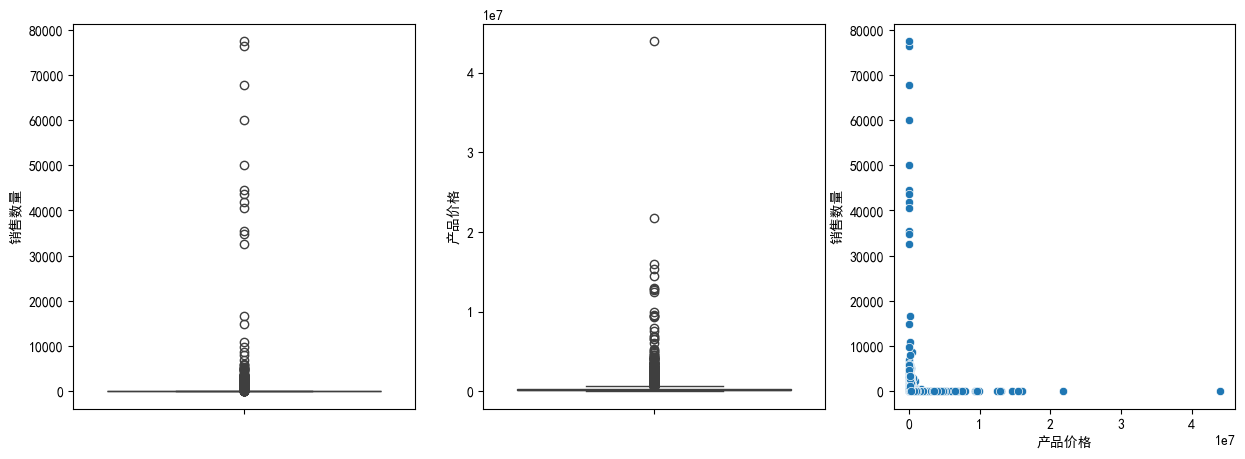

In [95]:
fig,axes = plt.subplots(1,3,figsize = (15,5))
sns.boxplot(all_cleandata_expanded["销售数量"],ax = axes[0])
sns.boxplot(all_cleandata_expanded["产品价格"],ax = axes[1])
sns.scatterplot(data = all_cleandata_expanded,x = all_cleandata_expanded["产品价格"],y = all_cleandata_expanded["销售数量"],ax = axes[2])
plt.show()

###### 计算剔除极端数据

In [153]:
# 计算Q1和Q3
Q1 = all_cleandata_expanded['产品价格'].quantile(0.25)
Q3 = all_cleandata_expanded['产品价格'].quantile(0.75)

# 计算IQR
IQR = Q3 - Q1

# 定义异常值的范围
outlier_step = 1.5 * IQR

# 确定数据中的异常值
outliers = all_cleandata_expanded[(all_cleandata_expanded['产品价格'] < Q1 - outlier_step) | (all_cleandata_expanded['产品价格'] > Q3 + outlier_step)]

# 剔除异常值
all_expanded_cleaned_6 = all_cleandata_expanded[~((all_cleandata_expanded['产品价格'] < Q1 - outlier_step) | (all_cleandata_expanded['产品价格'] > Q3 + outlier_step))]

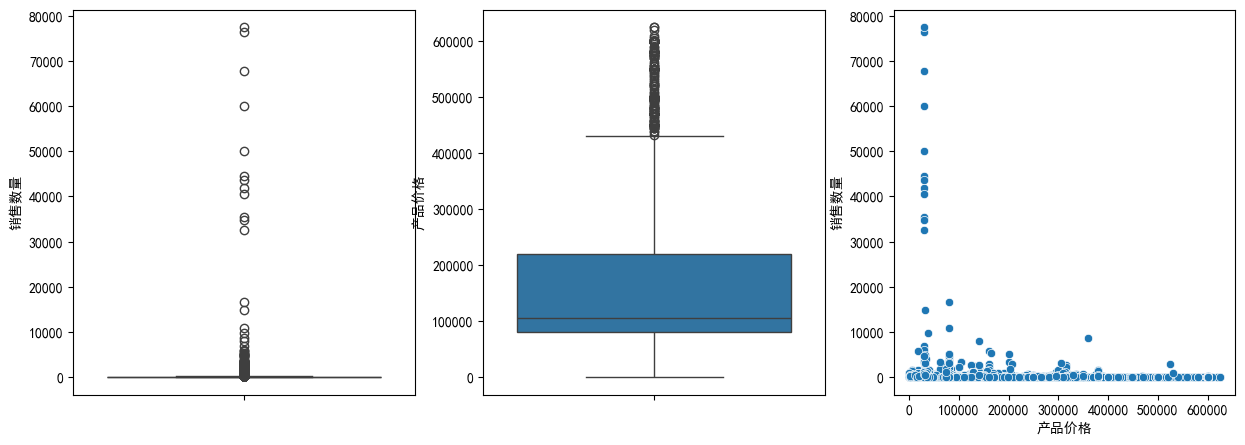

In [154]:
fig,axes = plt.subplots(1,3,figsize = (15,5))
sns.boxplot(all_expanded_cleaned_6["销售数量"],ax = axes[0])
sns.boxplot(all_expanded_cleaned_6["产品价格"],ax = axes[1])
sns.scatterplot(data = all_expanded_cleaned_6,x = all_expanded_cleaned_6["产品价格"],y = all_expanded_cleaned_6["销售数量"],ax = axes[2])
plt.show()

In [110]:
# 计算销量的Q1和Q3
Q1_sales = all_cleandata_expanded['销售数量'].quantile(0.25)
Q3_sales = all_cleandata_expanded['销售数量'].quantile(0.75)
IQR_sales = Q3_sales - Q1_sales
outlier_step_sales = 1.5 * IQR_sales

# 计算产品价格的Q1和Q3
Q1_price = all_cleandata_expanded['产品价格'].quantile(0.25)
Q3_price = all_cleandata_expanded['产品价格'].quantile(0.75)
IQR_price = Q3_price - Q1_price
outlier_step_price = 1.5 * IQR_price

# 剔除销量和产品价格的异常值
df_cleaned = all_cleandata_expanded[
    ~((all_cleandata_expanded['销售数量'] < Q1_sales - outlier_step_sales) | (all_cleandata_expanded['销售数量'] > Q3_sales + outlier_step_sales)) &
    ~((all_cleandata_expanded['产品价格'] < Q1_price - outlier_step_price) | (all_cleandata_expanded['产品价格'] > Q3_price + outlier_step_price))
]

###### 图表

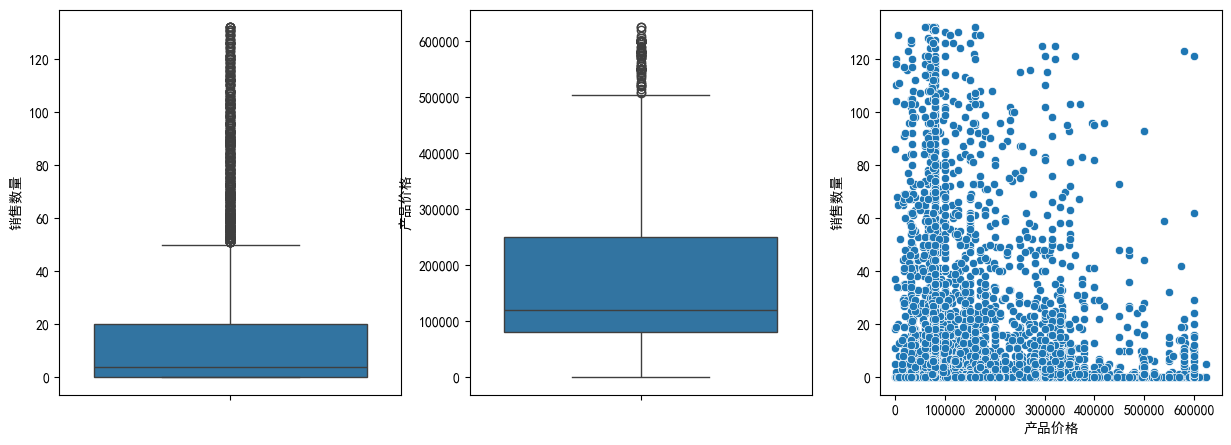

In [111]:
fig,axes = plt.subplots(1,3,figsize = (15,5))
sns.boxplot(df_cleaned["销售数量"],ax = axes[0])
sns.boxplot(df_cleaned["产品价格"],ax = axes[1])
sns.scatterplot(data = df_cleaned,x = df_cleaned["产品价格"],y = df_cleaned["销售数量"],ax = axes[2])
plt.show()

通过总体和剔除极端值的数据综合观察可知，电子烟类目目前极少存在高价格高销量的产品；  
在80-100k价位段销量会有一个峰值，250-350k价位销量会有一个峰值，600k价位销量会有一个峰值；  
整体销量与价格呈反比关系。

##### **探索价格与转化率的关系**

观察总体数据情况

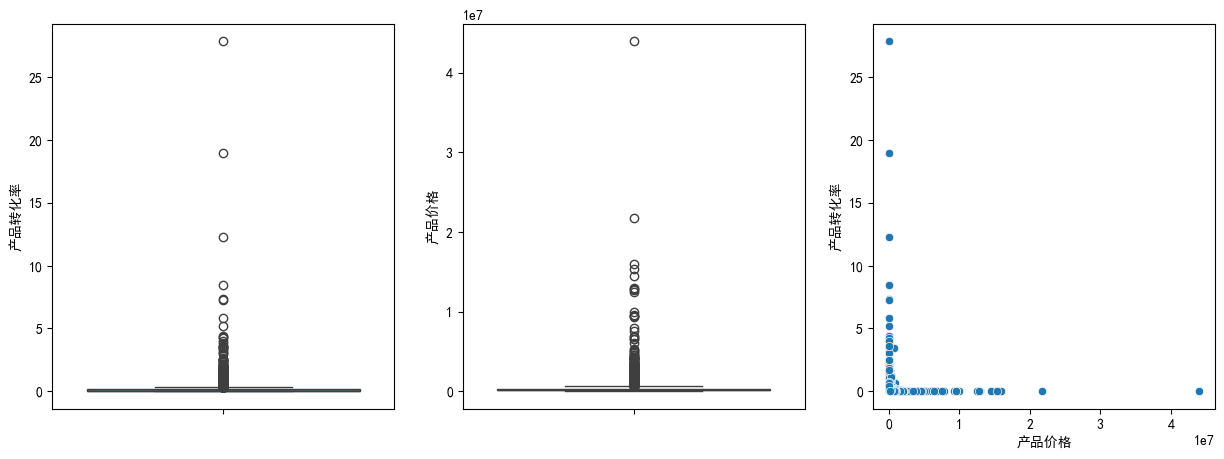

In [140]:
fig,axes = plt.subplots(1,3,figsize = (15,5))
sns.boxplot(all_cleandata_expanded["产品转化率"],ax = axes[0])
sns.boxplot(all_cleandata_expanded["产品价格"],ax = axes[1])
sns.scatterplot(data = all_cleandata_expanded,x = all_cleandata_expanded["产品价格"],y = all_cleandata_expanded["产品转化率"],ax = axes[2])
plt.show()

###### 计算剔除极端数据

In [144]:
# 计算访问量的Q1和Q3
Q1_Conversion_rate = all_cleandata_expanded['产品转化率'].quantile(0.25)
Q3_Conversion_rate = all_cleandata_expanded['产品转化率'].quantile(0.75)
IQR_Conversion_rate = Q3_Conversion_rate - Q1_Conversion_rate
outlier_step_Conversion_rate = 1.5 * IQR_Conversion_rate

# 计算产品价格的Q1和Q3
Q1_price = all_cleandata_expanded['产品价格'].quantile(0.25)
Q3_price = all_cleandata_expanded['产品价格'].quantile(0.75)
IQR_price = Q3_price - Q1_price
outlier_step_price = 1.5 * IQR_price

# 剔除销量和产品价格的异常值
df_cleaned_3 = all_cleandata_expanded[
    ~((all_cleandata_expanded['产品转化率'] < Q1_Conversion_rate - outlier_step_Conversion_rate) | (all_cleandata_expanded['产品转化率'] > Q3_Conversion_rate + outlier_step_Conversion_rate)) &
    ~((all_cleandata_expanded['产品价格'] < Q1_price - outlier_step_price) | (all_cleandata_expanded['产品价格'] > Q3_price + outlier_step_price))
]

###### 图表

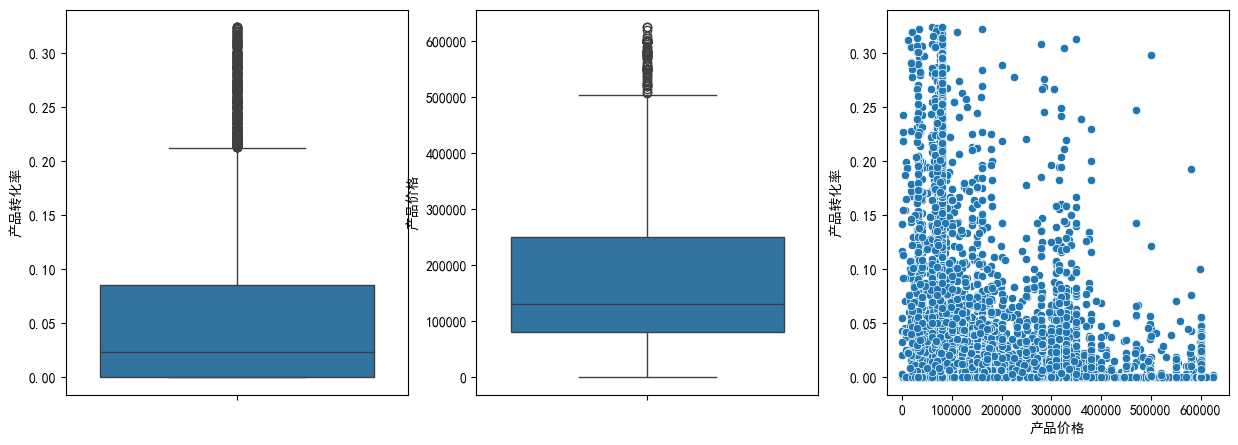

In [145]:
fig,axes = plt.subplots(1,3,figsize = (15,5))
sns.boxplot(df_cleaned_3["产品转化率"],ax = axes[0])
sns.boxplot(df_cleaned_3["产品价格"],ax = axes[1])
sns.scatterplot(data = df_cleaned_3,x = df_cleaned_3["产品价格"],y = df_cleaned_3["产品转化率"],ax = axes[2])
plt.show()

可以看出转化率高的价位段是80k左右，50k-20k价位段的转化率也相对较高但低于80k价位段，还有两个价位段峰值是300k和150k

##### **观察价格与访问数量的关系**

观察总体数据情况

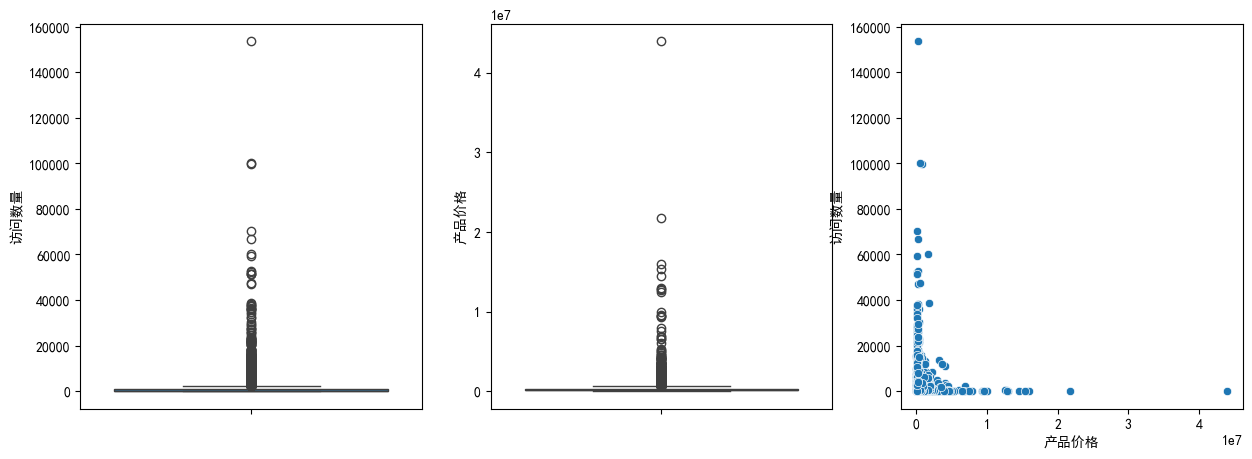

In [101]:
fig,axes = plt.subplots(1,3,figsize = (15,5))
sns.boxplot(all_cleandata_expanded["访问数量"],ax = axes[0])
sns.boxplot(all_cleandata_expanded["产品价格"],ax = axes[1])
sns.scatterplot(data = all_cleandata_expanded,x = all_cleandata_expanded["产品价格"],y = all_cleandata_expanded["访问数量"],ax = axes[2])
plt.show()

###### 计算剔除极端数据

In [142]:
# 计算访问量的Q1和Q3
Q1_Views = all_cleandata_expanded['访问数量'].quantile(0.25)
Q3_Views = all_cleandata_expanded['访问数量'].quantile(0.75)
IQR_Views = Q3_Views - Q1_Views
outlier_step_Views = 1.5 * IQR_Views

# 计算产品价格的Q1和Q3
Q1_price = all_cleandata_expanded['产品价格'].quantile(0.25)
Q3_price = all_cleandata_expanded['产品价格'].quantile(0.75)
IQR_price = Q3_price - Q1_price
outlier_step_price = 1.5 * IQR_price

# 剔除销量和产品价格的异常值
df_cleaned_1 = all_cleandata_expanded[
    ~((all_cleandata_expanded['访问数量'] < Q1_Views - outlier_step_Views) | (all_cleandata_expanded['访问数量'] > Q3_Views + outlier_step_Views)) &
    ~((all_cleandata_expanded['产品价格'] < Q1_price - outlier_step_price) | (all_cleandata_expanded['产品价格'] > Q3_price + outlier_step_price))
]

###### 图表

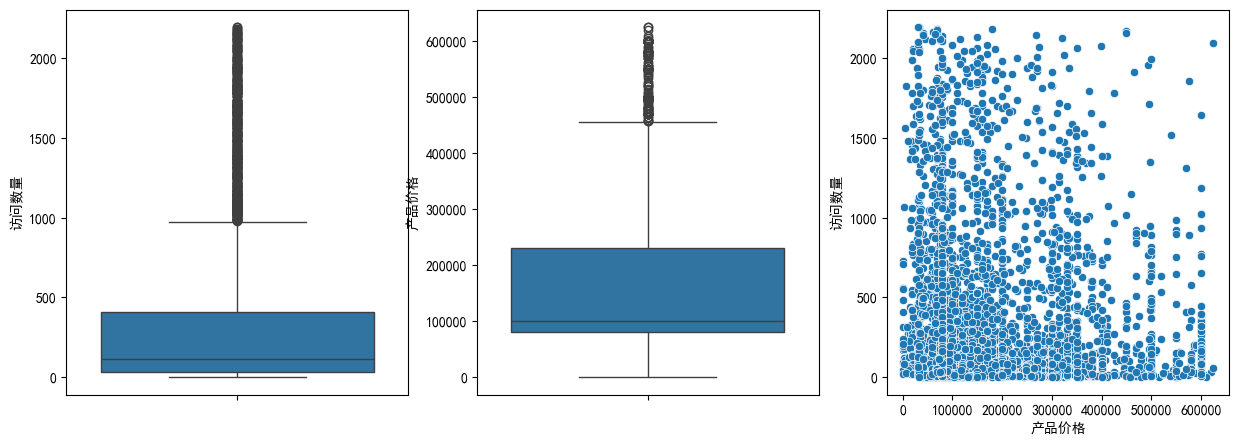

In [113]:
fig,axes = plt.subplots(1,3,figsize = (15,5))
sns.boxplot(df_cleaned_1["访问数量"],ax = axes[0])
sns.boxplot(df_cleaned_1["产品价格"],ax = axes[1])
sns.scatterplot(data = df_cleaned_1,x = df_cleaned_1["产品价格"],y = df_cleaned_1["访问数量"],ax = axes[2])
plt.show()

通过总体和剔除极端值的数据综合观察可知，产品价格与访问量同样呈反比关系；   
在80k价位段以下的访问量会有一个峰值，在150-200k价位段访问量会有一个峰值，300k价位访问量会有一个峰值；  
结合上面价格与销量的关系可以初步判断出，50k价位段以下的产品虽然可以吸引到访问量，但转化不会有80-100k价位段的产品高；  
200k价位段的访问量跟300k价位段的访问量相差不多。

##### **观察销售数量与访问数量的关系**

观察总体数据情况

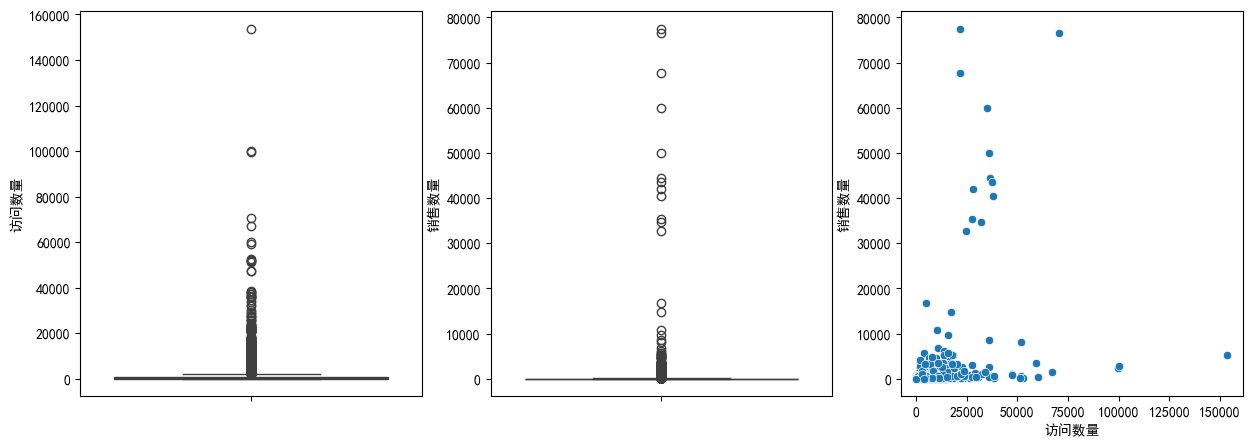

In [116]:
fig,axes = plt.subplots(1,3,figsize = (15,5))
sns.boxplot(all_cleandata_expanded["访问数量"],ax = axes[0])
sns.boxplot(all_cleandata_expanded["销售数量"],ax = axes[1])
sns.scatterplot(data = all_cleandata_expanded,x = all_cleandata_expanded["访问数量"],y = all_cleandata_expanded["销售数量"],ax = axes[2])
plt.show()

###### 计算剔除极端数据

In [114]:
# 计算访问量的Q1和Q3
Q1_Views = all_cleandata_expanded['访问数量'].quantile(0.25)
Q3_Views = all_cleandata_expanded['访问数量'].quantile(0.75)
IQR_Views = Q3_Views - Q1_Views
outlier_step_Views = 1.5 * IQR_Views

# 计算销量的Q1和Q3
Q1_sales = all_cleandata_expanded['销售数量'].quantile(0.25)
Q3_sales = all_cleandata_expanded['销售数量'].quantile(0.75)
IQR_sales = Q3_sales - Q1_sales
outlier_step_sales = 1.5 * IQR_sales

# 剔除销量和产品价格的异常值
df_cleaned_2 = all_cleandata_expanded[
    ~((all_cleandata_expanded['访问数量'] < Q1_Views - outlier_step_Views) | (all_cleandata_expanded['访问数量'] > Q3_Views + outlier_step_Views)) &
    ~((all_cleandata_expanded['销售数量'] < Q1_sales - outlier_step_sales) | (all_cleandata_expanded['销售数量'] > Q3_sales + outlier_step_sales))
]

###### 图表

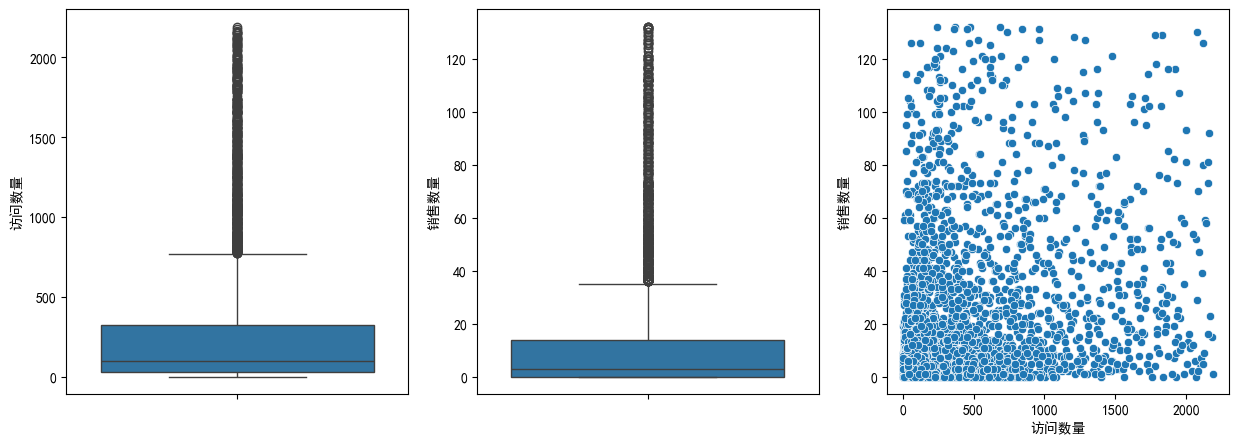

In [115]:
fig,axes = plt.subplots(1,3,figsize = (15,5))
sns.boxplot(df_cleaned_2["访问数量"],ax = axes[0])
sns.boxplot(df_cleaned_2["销售数量"],ax = axes[1])
sns.scatterplot(data = df_cleaned_2,x = df_cleaned_2["访问数量"],y = df_cleaned_2["销售数量"],ax = axes[2])
plt.show()

通过总体和剔除极端值的数据综合观察可知：   
大部分产生销量的产品的访问量都在1000访问量以内，访问量达到100左右时会有销量峰值，之后逐步递减；  
大致可以推断出新品期的产品可能会产生更好的销量。

##### **观察评价数与访问量的关系**

观察总体数据情况

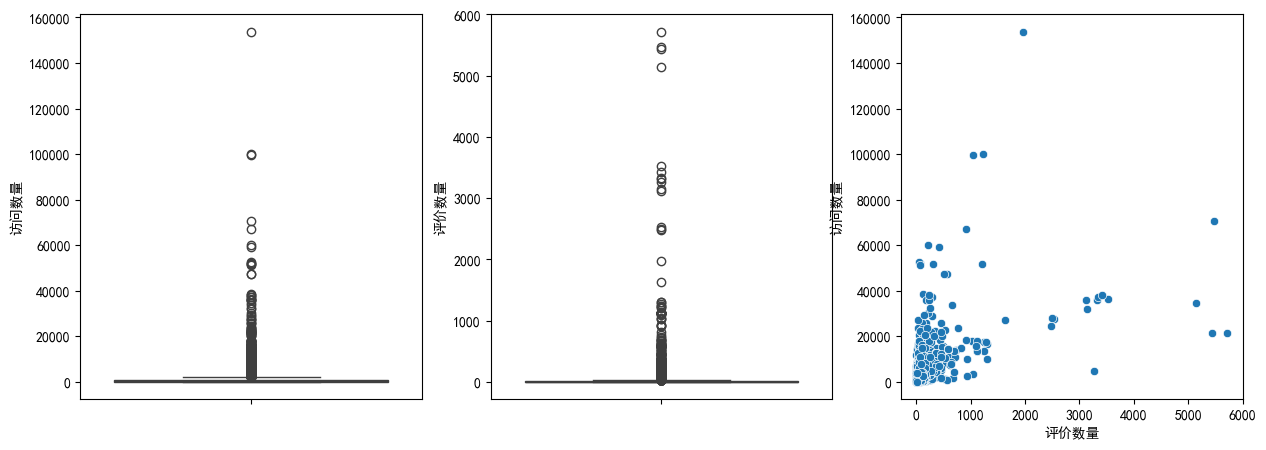

In [147]:
fig,axes = plt.subplots(1,3,figsize = (15,5))
sns.boxplot(all_cleandata_expanded["访问数量"],ax = axes[0])
sns.boxplot(all_cleandata_expanded["评价数量"],ax = axes[1])
sns.scatterplot(data = all_cleandata_expanded,x = all_cleandata_expanded["评价数量"],y = all_cleandata_expanded["访问数量"],ax = axes[2])
plt.show()

###### 计算剔除极端数据

In [148]:
# 计算访问量的Q1和Q3
Q1_Views = all_cleandata_expanded['访问数量'].quantile(0.25)
Q3_Views = all_cleandata_expanded['访问数量'].quantile(0.75)
IQR_Views = Q3_Views - Q1_Views
outlier_step_Views = 1.5 * IQR_Views

# 计算销量的Q1和Q3
Q1_reviews = all_cleandata_expanded['评价数量'].quantile(0.25)
Q3_reviews = all_cleandata_expanded['评价数量'].quantile(0.75)
IQR_reviews = Q3_reviews - Q1_reviews
outlier_step_reviews = 1.5 * IQR_reviews

# 剔除销量和产品价格的异常值
df_cleaned_4 = all_cleandata_expanded[
    ~((all_cleandata_expanded['访问数量'] < Q1_Views - outlier_step_Views) | (all_cleandata_expanded['访问数量'] > Q3_Views + outlier_step_Views)) &
    ~((all_cleandata_expanded['评价数量'] < Q1_reviews - outlier_step_reviews) | (all_cleandata_expanded['评价数量'] > Q3_reviews + outlier_step_reviews))
]

###### 图表

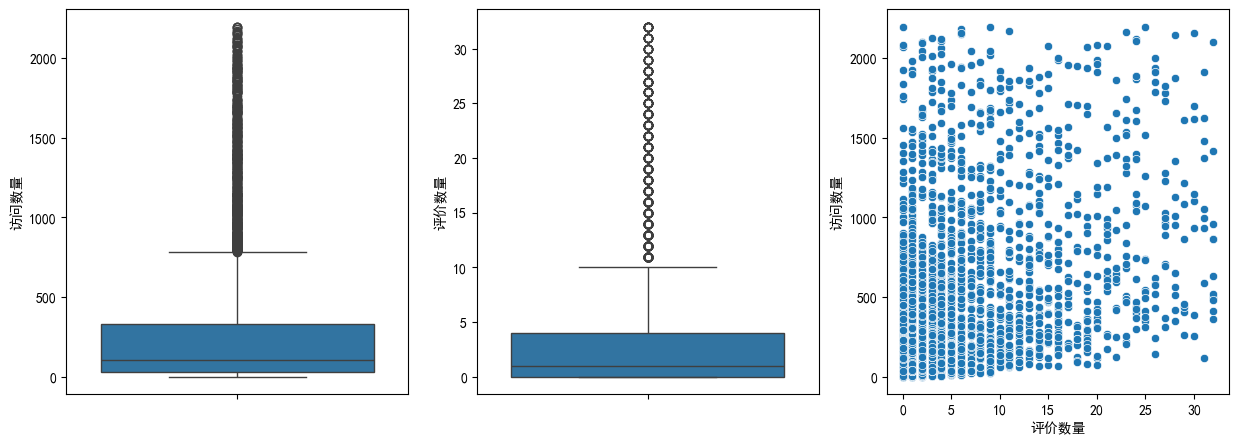

In [149]:
fig,axes = plt.subplots(1,3,figsize = (15,5))
sns.boxplot(df_cleaned_4["访问数量"],ax = axes[0])
sns.boxplot(df_cleaned_4["评价数量"],ax = axes[1])
sns.scatterplot(data = df_cleaned_4,x = df_cleaned_4["评价数量"],y = df_cleaned_4["访问数量"],ax = axes[2])
plt.show()

评价数与访问量呈正向关系，且对于新品的流量扶持较为明显

##### **观察转化率分布形状**

###### 剔除极端值

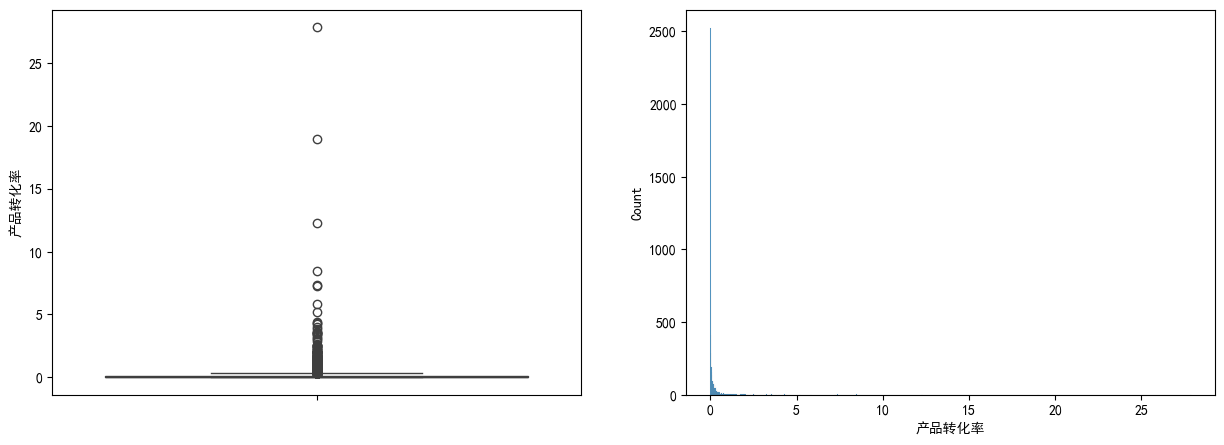

In [126]:
fig,axes = plt.subplots(1,2,figsize = (15,5))
sns.boxplot(all_cleandata_expanded["产品转化率"],ax = axes[0])
sns.histplot(data = all_cleandata_expanded,x = "产品转化率",ax = axes[1])
plt.show()

产品转化率存在异常值，可能是刷单，进行剔除

In [127]:
# 计算Q1和Q3
Q1 = all_cleandata_expanded['产品转化率'].quantile(0.25)
Q3 = all_cleandata_expanded['产品转化率'].quantile(0.75)

# 计算IQR
IQR = Q3 - Q1

# 定义异常值的范围
outlier_step = 1.5 * IQR

# 确定数据中的异常值
outliers = all_cleandata_expanded[(all_cleandata_expanded['产品转化率'] < Q1 - outlier_step) | (all_cleandata_expanded['产品转化率'] > Q3 + outlier_step)]

# 剔除异常值
all_expanded_cleaned_1 = all_cleandata_expanded[~((all_cleandata_expanded['产品转化率'] < Q1 - outlier_step) | (all_cleandata_expanded['产品转化率'] > Q3 + outlier_step))]

###### 图表

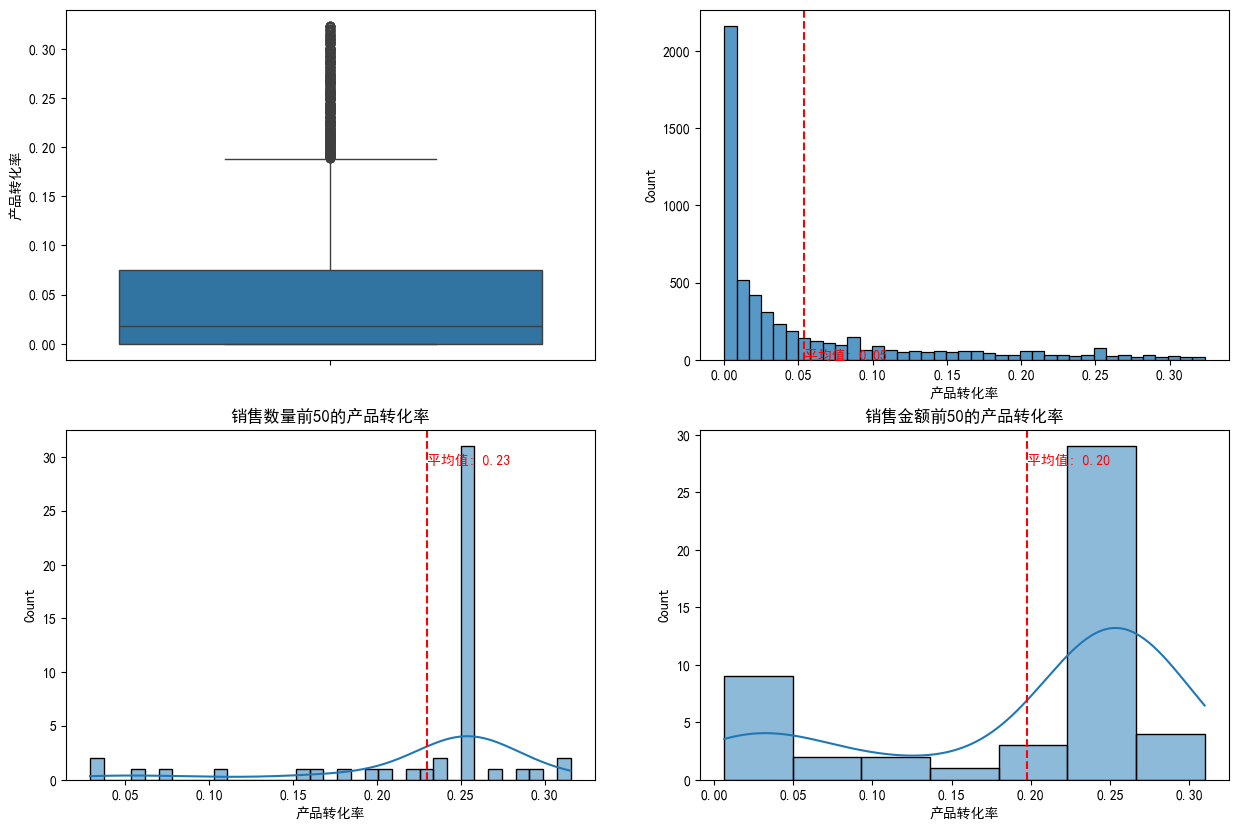

In [139]:
fig,axes = plt.subplots(2,2,figsize = (15,10))
sns.boxplot(all_expanded_cleaned_1["产品转化率"],ax = axes[0,0])
# 计算平均值
mean_value = all_expanded_cleaned_1['产品转化率'].mean()
# 绘制直方图
sns.histplot(data=all_expanded_cleaned_1, x='产品转化率', ax=axes[0,1])
# 在直方图上添加平均值的垂直线
axes[0,1].axvline(mean_value, color='r', linestyle='--')
# 添加一个标签来注释平均值
axes[0,1].text(mean_value, plt.gca().get_ylim()[1]*0.9, f'平均值: {mean_value:.2f}', color='r')

# 获取销售数量前50的产品
top50_quantity = all_expanded_cleaned_1.nlargest(50, '销售数量')
# 获取销售金额前50的产品
top50_sales = all_expanded_cleaned_1.nlargest(50, '产品GMV')
# 绘制销售数量前50产品的转化率直方图
sns.histplot(top50_quantity['产品转化率'], ax=axes[1,0], kde=True)
mean_conversion_quantity = top50_quantity['产品转化率'].mean()
axes[1,0].axvline(mean_conversion_quantity, color='r', linestyle='--')
axes[1,0].text(mean_conversion_quantity, axes[1,0].get_ylim()[1]*0.9, f'平均值: {mean_conversion_quantity:.2f}', color='r')
axes[1,0].set_title('销售数量前50的产品转化率')

# 绘制销售金额前50产品的转化率直方图
sns.histplot(top50_sales['产品转化率'], ax=axes[1,1], kde=True)
mean_conversion_sales = top50_sales['产品转化率'].mean()
axes[1,1].axvline(mean_conversion_sales, color='r', linestyle='--')
axes[1,1].text(mean_conversion_sales, axes[1,1].get_ylim()[1]*0.9, f'平均值: {mean_conversion_sales:.2f}', color='r')
axes[1,1].set_title('销售金额前50的产品转化率')
plt.show()

可以看到剔除极端值后电子烟类目的平均转化率为5%，销量前50的产品平均转化率为23%，销售金额前50的产品平均转化率为20%

##### **认证商家数量占比**

In [ ]:
是否是认证商家

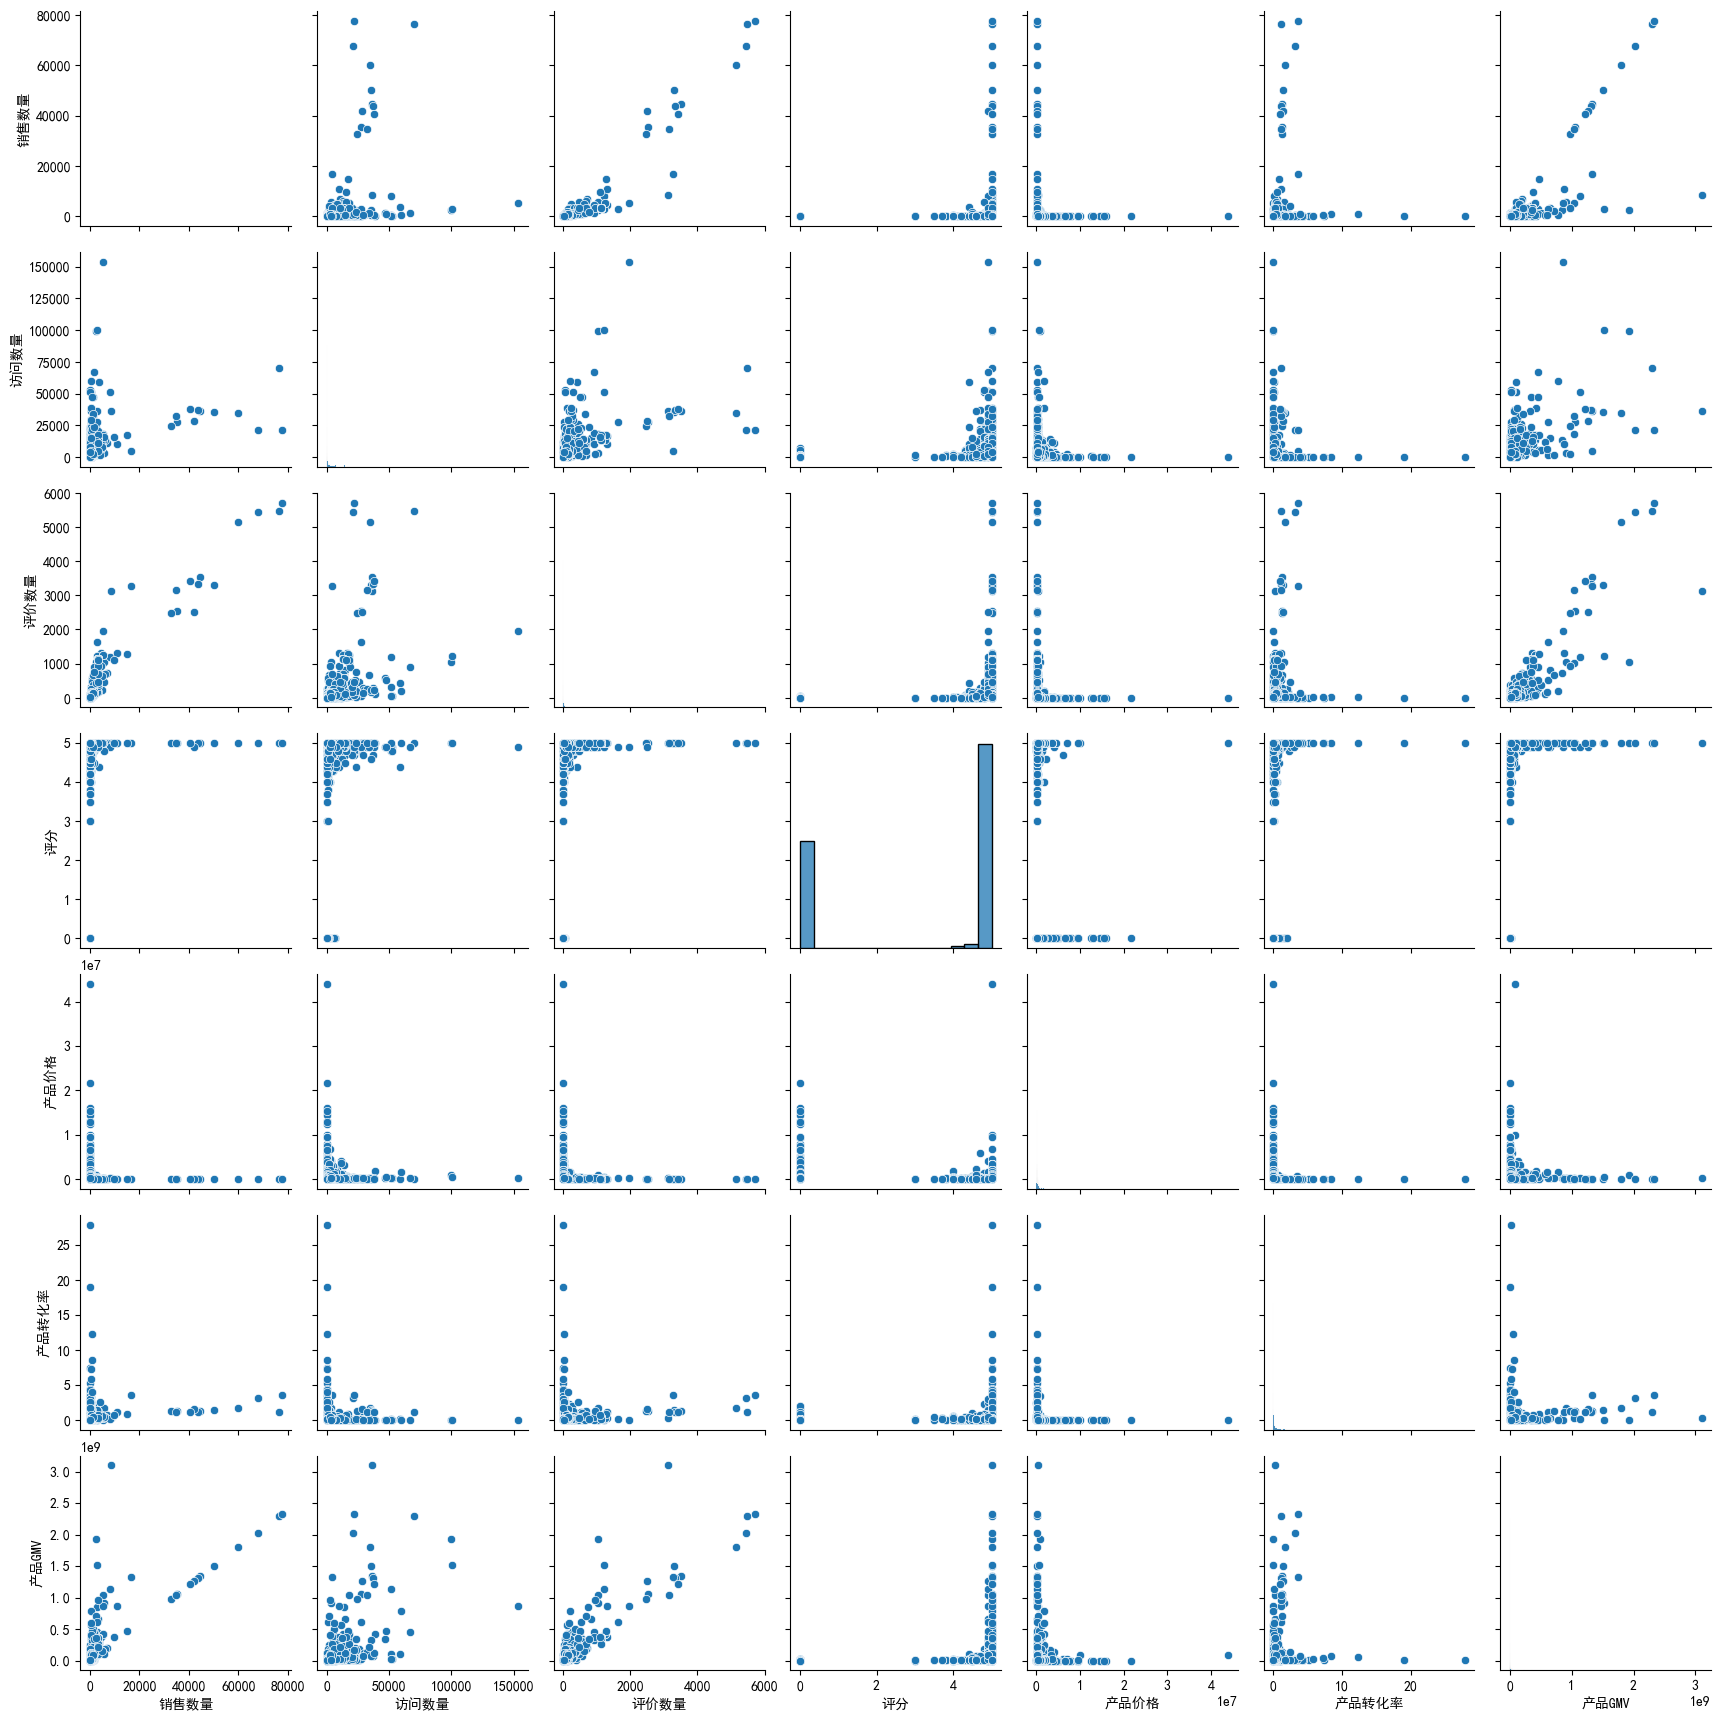

In [151]:
columns_of_interest = ['销售数量', '访问数量', '评价数量','评分','产品价格','产品转化率','产品GMV']
sns.pairplot(all_cleandata_expanded, vars=columns_of_interest)
plt.show()